# QML Na Prática: Variational Quantum Eigensolver

In [2]:
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install qiskit
%pip install qiskit_aer
%pip install qiskit_optimization

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 0 - Definição do Problema

Temos um grupo de 6 pessoas e queremos dividí-las em duas equipes, de forma que o nível de habilidade de cada uma seja similar.
- Cada pessoa tem um nível de habilidade
- Algumas pessoas são goleiros

`Objetivo`: separar os jogadores em duas equipes
- > as equipes devem ter habilidades iguais (ou próximas)
- nem todos precisam ser escolhidos
- as equipes não necessariamente precisam ter a mesma quantidade de integrantes

`Restrições`:
- > cada jogador não pode estar em mais de uma equipe
- > cada equipe deve ter exatamente um goleiro

### Dados dos Jogadores

| Jogador | Habilidade | Goleiro? |
|---------|------------|----------|
| Alice   |      5     | Não      |
| Bob     |      6     | Sim      |
| Claire  |      8     | Sim      |
| Danny   |      4     | Não      |
| Eve     |      6     | Não      |
| Frank   |      9     | Não      |

## 1 - Mapeamento

Utilizaremos variáveis binárias para escrever o problema no modelo QUBO.

As variáveis $(x_0,\dots, x_5)$ representam os jogadores no **Time A**
As variáveis $(x_6,\dots, x_{11})$ representam os jogadores no **Time B**

Se $x_i=1$, o jogador correspondente está no time associado a $i$; caso contrário, $x_i=0$.
- Por exemplo, $x_0=1$ e $x_6=0$ significa que Alice *está* no Time A e *não está* no Time B.

### Função Objetivo

Se nós formos criar duas equipes, podemos definiar a função como:

$$Obj = \left(\sum s_A - \sum s_B\right)^2$$

Em que $\sum s_i$ representa a habilidade total dos jogadores do Time $i$.

Elevamos ao quadrado para que o valor seja sempre positivo, evitando que o algoritmo atribua todos os jogadores em uma mesma equipe
- Este erro poderia acontecer caso a habilidade da equipe B seja muito maior do que a de A, gerando um resultado muito negativo
- Elevando ao quadrado, o menor valor possível é zero (caso as equipes tenha habilidade igual)

Para tornar o resultado genérico para $N$ equipes (além de nos possibilitar fazer ajustes no modelo de equipes específicas), podemos generalizar a função objetivo, calculando objetivos específicos para cada equipe.

Para tal, podemos calcular a diferença de habilidade entre cada equipe $i$ e a distribuição "justa" de habilidades, $ED$:

$$ED=\frac{\sum s_i}{N}$$

Em que $s_i$ é a habilidade de cada pessoa e $N$ é o número de equipes.

Nesse caso, a função objetivo será:

$$Obj=\sum_i O_i$$

Em que:

$$O_i = \left(\sum (s_ix_i) - ED\right)$$

Com $s_i$ sendo a habilidade de cada jogador $i$ e $x_i$ a variável indicando se $i$ deve ou não estar no time.
- Por exemplo, estamos falando de Alice quando $i=0$ ou $i=6$, logo, $s_0=s_6=5$

Expandindo a função no nosso caso, temos:

$$ED = \frac{\sum s_i}{2}=19$$

$$O_0 = \left(\sum_{i\in[0,5]}s_ix_i - ED  \right)^2 = [(5x_0 + 6x_1 + 8x_2 + 4x_3 + 6x_4 + 9x_5) - ED]^2$$
$$O_1 = \left(\sum_{i\in[6,11]}s_ix_i - ED  \right)^2 = [(5x_6 + 6x_7 + 8x_8 + 4x_9 + 6x_{10} + 9x_{11}) - ED]^2$$
$$Obj = [(5x_0 + 6x_1 + 8x_2 + 4x_3 + 6x_4 + 9x_5) - 19]^2 + [(5x_6 + 6x_7 + 8x_8 + 4x_9 + 6x_{10} + 9x_{11}) - 19]^2$$

Apesar de ser um problema no modelo de QUBO válido, ainda podemos dar problemas, por exemplo:
- Alocar todos os jogadores em um único time
- Alocar um jogador a todos os times
- Não alocar jogadores, mantendo $N$ times com $0$ integrantes (por consequência, $Obj=0$, como queríamos, mas não de uma forma correta)

Para contornar possíveis problemas, adicionamos restrições ao modelo.

### Funções de Penalidade

Para cada restrição do problema, adicionamos um termo ao nosso modelo contendo uma função que a represente.

A primeira restrição (um jogador não pode estar em mais de uma equipe) pode ser escrita como:

$$x + y \leq 1$$

Como nossas variáveis só podem assumir os valores $0$ ou $1$, a desigualdade obriga que ao menos uma das variáveis seja igual a $0$.

Este tipo de restrição é tão comum que temos uma função de penalização pronta para ela:

$$\lambda(xy)$$

Em que $\lambda$ é uma constante de penalização, que será decidida posteriormente.

No caso, para cara jogador (e seu par de variáveis associadas), teremos um termo de penalidade. Por exemplo, para Alice:

$$x_0+x_6 \leq 1 \xrightarrow{} \lambda_1(x_0x_6)=c_1$$

Nosso segundo tipo de restrição diz respeito aos goleiros; para tal, basta fazer algo parecido.

Para garantir que cada goleiro está em no máximo uma das equipes, fazemos uma restrição dizendo que não podemos ter mais de um goleiro em determinado time.

Como o nosso exemplo tem dois goleiros:

$$x_1+x_2 \leq 1 \xrightarrow{} \lambda_2(x_1x_2)=c_7$$
$$x_7+x_8 \leq 1 \xrightarrow{} \lambda_2(x_7x_8)=c_8$$

Nós somaremos as funções de penalidade dos termos da função objetivo, garantindo que as restrições se apliquem.

Para escolher os valores de $\lambda$ precisamos ter em conta que:
- Normalmente utilizamos valores inteiros
- Devem ser valores grandes o bastante para aumentar o valor da função objetivo se a restrição for descumprida
- Não podem ser valores muito altos, para não enviesar a função objetivo
- - O modelo se preocuparia mais em satisfazer todas as restrições do que em minimizar a função
- Não podem ser valores muito baixos, do contrário o modelo permitiria violações demais

### Código do Mapeamento

Dessa forma, nossa função final será a função de custo $C$ tal que:

$$C = Obj + \sum c_i$$

Em que $c_i$ são as funções de penalidade.

Assim:

$$C = \sum O_i + \sum c_i$$
$$C = \left(\sum_{i\in[0,5]}s_ix_i - ED  \right)^2 + \left(\sum_{i\in[6,11]}s_ix_i - ED  \right)^2 + \lambda_1(x_0x_6 + \dots + x_5x_{11}) + \lambda_2(x_1x_2 + x_7x_8)$$

Podemos, finalmente, mapear nosso problema para um computador quântico utilizando Qiskit.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Sequence

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

In [6]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.primitives import Sampler as AerSampler

In [7]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

In [8]:
# Dados do problema
players_data = [
    {"name": "Alice",  "strength": 5, "isGoalkeeper": False},
    {"name": "Bob",    "strength": 6, "isGoalkeeper": True },
    {"name": "Claire", "strength": 8, "isGoalkeeper": True },
    {"name": "Danny",  "strength": 4, "isGoalkeeper": False},
    {"name": "Eve",    "strength": 6, "isGoalkeeper": False},
    {"name": "Frank",  "strength": 9, "isGoalkeeper": False},
]

teams = ["Alpha", "Beta"]
num_players = len(players_data)
num_teams = len(teams)

In [9]:
strengths = [p['strength'] for p in players_data]
goalkeeper_indices = [i for i, p in enumerate(players_data) if p['isGoalkeeper']]

In [10]:
total_strength = sum(strengths)
equal_dist = total_strength / num_teams

In [11]:
# Criar o modelo de otimização
qp = QuadraticProgram("FootballTeamSelection")

In [12]:
# 1. Definir as variáveis binárias
for i in range(num_players):
    for t in range(num_teams):
        qp.binary_var(name=f'x_{i}_{t}')

A Função objetivo no código vem da expansão de nossos $O_i$. Seja $X_i$ a força total do time $i$:

$$O_i = \left(X_i - ED\right)^2 = X_i^2 - 2\cdot X_i\cdot ED + ED^2$$

- $X_i^2$ vem da força total do time; na expansão, cada jogador $i$ é multiplicado por cada jogador $j$ do mesmo time (pois é a multiplicação de uma soma).
- - Por isso, dizemos que este é o termo _quadrático_, pois depende de dois jogadores por vez.

- $(-2)\cdot X_i\cdot ED$ é um coeficiente que depende apenas de cada jogador $i$ uma vez.
- - Por isso, dizemos que este é o termo _linear_, por só variar com um jogador.

- $ED^2$, por sua vez, não depende de nenhum jogador.
- - Como seu valor é sempre o mesmo, dizemos ser o termo _constante_.

In [13]:
# 2. Definir a função objetivo 

linear_coeffs = {}
quadratic_coeffs = {}
constant = num_teams * (equal_dist ** 2)

for t in range(num_teams):
    for i in range(num_players):
        # Termo linear:
        var_name = f'x_{i}_{t}'
        linear_coeffs[var_name] = -2 * strengths[i] * equal_dist
        
        for j in range(num_players):
            # Termo quadrático:
            var1_name = f'x_{i}_{t}'
            var2_name = f'x_{j}_{t}'
            quadratic_coeffs[(var1_name, var2_name)] = strengths[i] * strengths[j]

qp.minimize(constant=constant, linear=linear_coeffs, quadratic=quadratic_coeffs)

In [14]:
# 3. Adicionar as restrições

# Cada jogador em exatamente um time
for i in range(num_players):
    player_assignment_vars = {f'x_{i}_{t}': 1 for t in range(num_teams)}
    qp.linear_constraint(linear=player_assignment_vars, sense='==', rhs=1, name=f'player_{i}_assignment')

# No máximo um goleiro por time
for t in range(num_teams):
    goalkeeper_assignment_vars = {f'x_{i}_{t}': 1 for i in goalkeeper_indices}
    qp.linear_constraint(linear=goalkeeper_assignment_vars, sense='<=', rhs=1, name=f'team_{t}_goalkeeper')

In [15]:
print("Modelo de Otimização (QuadraticProgram) definido.")
print(qp.prettyprint())

Modelo de Otimização (QuadraticProgram) definido.
Problem name: FootballTeamSelection

Minimize
  25*x_0_0^2 + 60*x_0_0*x_1_0 + 80*x_0_0*x_2_0 + 40*x_0_0*x_3_0 + 60*x_0_0*x_4_0
  + 90*x_0_0*x_5_0 + 25*x_0_1^2 + 60*x_0_1*x_1_1 + 80*x_0_1*x_2_1
  + 40*x_0_1*x_3_1 + 60*x_0_1*x_4_1 + 90*x_0_1*x_5_1 + 36*x_1_0^2
  + 96*x_1_0*x_2_0 + 48*x_1_0*x_3_0 + 72*x_1_0*x_4_0 + 108*x_1_0*x_5_0
  + 36*x_1_1^2 + 96*x_1_1*x_2_1 + 48*x_1_1*x_3_1 + 72*x_1_1*x_4_1
  + 108*x_1_1*x_5_1 + 64*x_2_0^2 + 64*x_2_0*x_3_0 + 96*x_2_0*x_4_0
  + 144*x_2_0*x_5_0 + 64*x_2_1^2 + 64*x_2_1*x_3_1 + 96*x_2_1*x_4_1
  + 144*x_2_1*x_5_1 + 16*x_3_0^2 + 48*x_3_0*x_4_0 + 72*x_3_0*x_5_0 + 16*x_3_1^2
  + 48*x_3_1*x_4_1 + 72*x_3_1*x_5_1 + 36*x_4_0^2 + 108*x_4_0*x_5_0 + 36*x_4_1^2
  + 108*x_4_1*x_5_1 + 81*x_5_0^2 + 81*x_5_1^2 - 190*x_0_0 - 190*x_0_1
  - 228*x_1_0 - 228*x_1_1 - 304*x_2_0 - 304*x_2_1 - 152*x_3_0 - 152*x_3_1
  - 228*x_4_0 - 228*x_4_1 - 342*x_5_0 - 342*x_5_1 + 722

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 == 1 

In [16]:
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)
hamiltonian, offset = qubo.to_ising()
num_qubits = hamiltonian.num_qubits

In [17]:
print(f"O problema foi mapeado para um Hamiltoniano de {num_qubits} qubits.")

O problema foi mapeado para um Hamiltoniano de 12 qubits.


In [18]:
hamiltonian

SparsePauliOp(['IIIIIIIIIZII', 'IIIIIIIZIIII', 'IIIIIIIIZIII', 'IIIIIIZIIIII', 'IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIZIIIZ', 'IIIIIZIIIIIZ', 'IIIZIIIIIIIZ', 'IZIIIIIIIIIZ', 'IIIIIIIIZIZI', 'IIIIIIZIIIZI', 'IIIIZIIIIIZI', 'IIZIIIIIIIZI', 'ZIIIIIIIIIZI', 'IIIIIIIIZZII', 'IIIIIIIZIZII', 'IIIIIZIIIZII', 'IIIZIIIIIZII', 'IZIIIIIIIZII', 'IIIIIIZIZIII', 'IIIIZIIIZIII', 'IIZIIIIIZIII', 'ZIIIIIIIZIII', 'IIIIIIZZIIII', 'IIIIIZIZIIII', 'IIIZIIIZIIII', 'IZIIIIIZIIII', 'IIIIZIZIIIII', 'IIZIIIZIIIII', 'ZIIIIIZIIIII', 'IIIIZZIIIIII', 'IIIZIZIIIIII', 'IZIIIZIIIIII', 'IIZIZIIIIIII', 'ZIIIZIIIIIII', 'IIZZIIIIIIII', 'IZIZIIIIIIII', 'ZIZIIIIIIIII', 'ZZIIIIIIIIII'],
              coeffs=[-1444.25+0.j, -1444.25+0.j, -1444.25+0.j, -1444.25+0.j,  8665.5 +0.j,
    15.  +0.j,    20.  +0.j,    10.  +0.j,    15.  +0.j,    22.5 +0.j,
    15.  +0.j,    20.  +0.j,    10.  +0.j,    15.  +0.j,    22.5 +0.j,
  8665.5 +0.j,  1468.25+0.j,    12.  +0.j,    18.  +0.j,    27.  +0.j,
  1468.25+0.j,    12.  +0.j,    18.  +0

## 2 - Preparação do VQE

Agora que temos nosso operador Hamiltoniano, podemos começar a definir o VQE propriamente dito.

Como utilizaremos simuladores, não precisamos nos preocupar com o transpilador (otimização complexa que prepara o circuito para o hardware real escolhido) e nem com mitigação de erros. Portanto, começemos pelo Ansatz.

### Ansatz

É um circuito quântico parametrizado. O VQE tentará encontrar os parâmetros que preparam o estado de menor energia. 
- O `EfficientSU2` é uma escolha comum, que tende a ser boa em vários casos.

Sendo um circuito, por baixo dos panos ele implementa portas lógicas e modos de entrelaçamento.

Para fins didáticos, podemos conferir o circuito interno, mas não é algo necessário.

/tmp/ipykernel_45566/3793753533.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear')


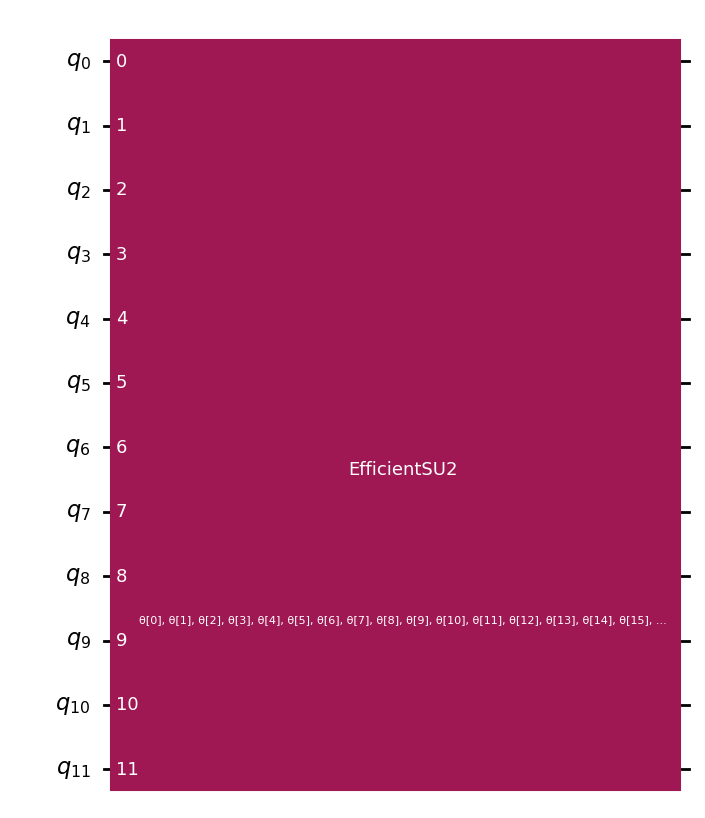

In [19]:
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear')

ansatz.draw("mpl")

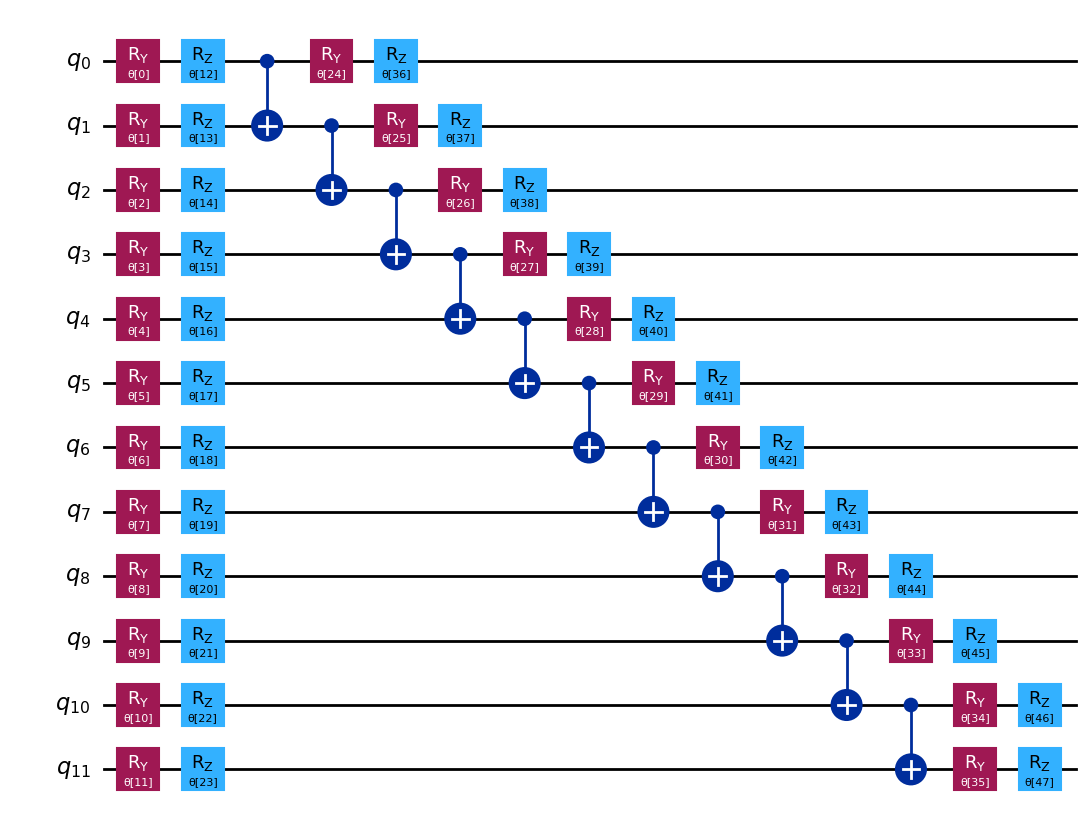

In [20]:
ansatz.decompose().draw("mpl")

Podemos alterar os parâmetros, como repetição (cria mais camadas de rotações e portas CNOT) e tipo de entrelaçamento.

Exemplificando, veja o circuito com entrelaçamento completo:

/tmp/ipykernel_45566/2482604393.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  EfficientSU2(num_qubits, reps=1, entanglement='full').decompose().draw("mpl")


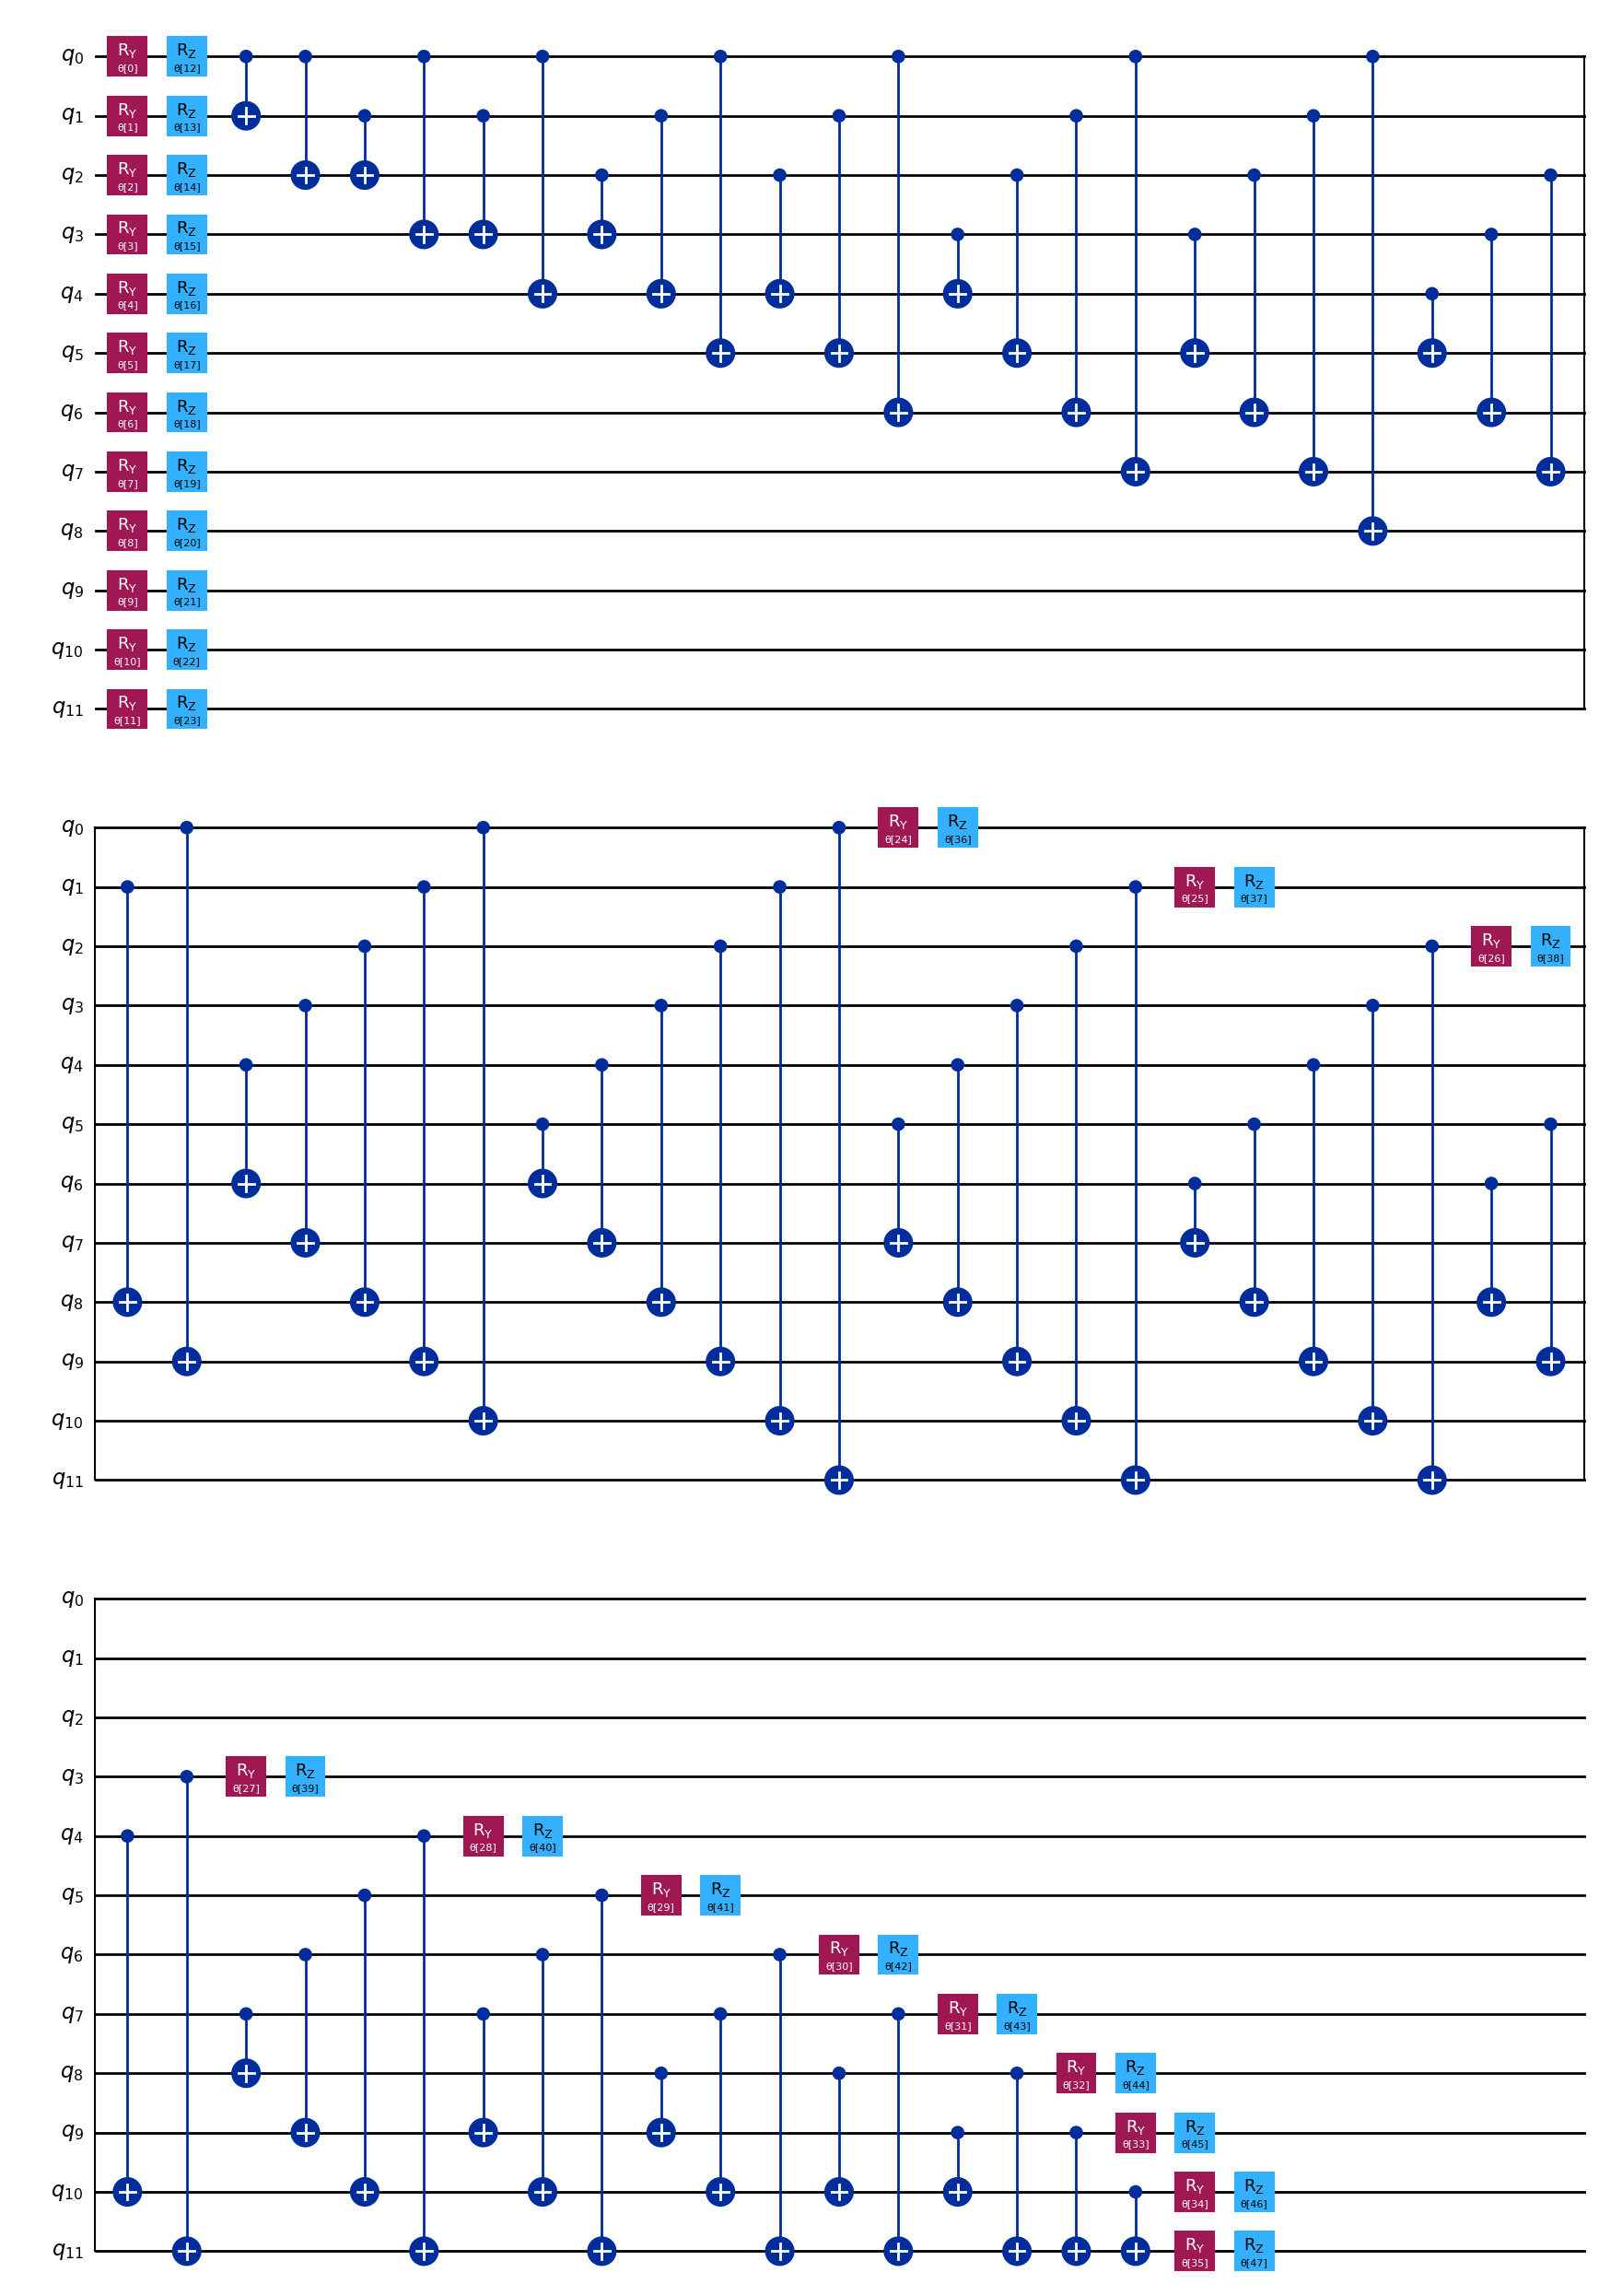

In [21]:
EfficientSU2(num_qubits, reps=1, entanglement='full').decompose().draw("mpl")

Apesar de ser um entrelaçamento mais forte entre os qubits, o número de portas lógicas aplicadas é muito maior.

Isso pode causar lentidão na execução do algoritmo, já que o circuito é mais complexo, e, pior ainda, aumenta exponencialmente a probabilidade de ocorrer erros caso tente executar o circuito em um computador real.

Para o nosso exemplo, vamos ficar com o entrelaçamento linear, mas utilizando duas repetições.

In [22]:
ansatz = EfficientSU2(num_qubits, reps=2, entanglement='linear')

/tmp/ipykernel_45566/1553661934.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits, reps=2, entanglement='linear')


### Otimizador Clássico

É o algoritmo clássico que ajustará os parâmetros do Ansatz.
- O `COBYLA` é uma boa opção para o nosso caso, já que não requer gradientes, sendo adequado para simuladores.

Além disso, precisamos definir um estimador, que executará o circuito e medirá os resultados.
- Para o nosso caso no simulador, utilizaremos o `AerEstimator`.

In [23]:
estimator = AerEstimator(
    run_options={"shots": None, "seed": 42}, # Usar um simulador ideal sem shot noise
    approximation=True # Permite o cálculo exato do valor esperado, sem amostragem
)

### Função de Custo

Aqui, vamos definir em código a função de custo que será minimizada pelo algoritmo.

Adicionaremos alguns logs que mostram como a energia vai mudando a cada iteração.

In [24]:
# Lista para armazenar o histórico de custos para plotagem posterior
cost_history = []
iteration_count = 0

In [25]:
# Função de custo que será minimizada (calcula a energia)
def cost_func(params: Sequence) -> float:
    """Calcula o valor esperado (energia) e registra o progresso."""
    global iteration_count
    
    # Cada pub é uma tupla de (circuito, observável, valores_dos_parâmetros)
    result = estimator.run(
        circuits=[ansatz], 
        observables=[hamiltonian], 
        parameter_values=[params]
    ).result()
    
    energy = result.values[0]
    
    cost_history.append(energy)
    iteration_count += 1
    print(f"Iteração: {iteration_count} | Custo (Energia): {energy:.5f}", end="\r", flush=True)
    
    return energy

### Execução do Algoritmo

Aqui, vamos definir os parâmetros iniciais para o algoritmo.

Então, construimos a função de minimização utilizando `scipy`, passando o otimizador que escolhemos mais cedo, e executamos o algoritmo.

In [26]:
# Parâmetros iniciais aleatórios
num_params = ansatz.num_parameters
np.random.seed(42) # Definindo seed para reprodutibilidade
initial_params = 2 * np.pi * np.random.random(num_params)

In [27]:
print("Iniciando a otimização com scipy.minimize...")

# Otimização usando o método COBYLA via SciPy
res = minimize(
    fun=cost_func,
    x0=initial_params,
    method="COBYLA",
    options={"maxiter": 300},
)
print("\nOtimização concluída.                                  ") # Espaços para limpar a linha do print

Iniciando a otimização com scipy.minimize...
Iteração: 300 | Custo (Energia): -43096.23013
Otimização concluída.                                  


In [28]:
optimal_params = res.x

# O valor da função retornado por `minimize` é o valor do Hamiltoniano
min_hamiltonian_value = res.fun
# A energia real do problema original inclui o offset da conversão para Ising
min_energy = min_hamiltonian_value + offset

In [29]:
print(f"Valor mínimo do Hamiltoniano (autovalor): {min_hamiltonian_value:.5f}")
print(f"Offset da conversão: {offset:.5f}")
print(f"Energia mínima final da solução (valor objetivo): {min_energy:.5f}")

Valor mínimo do Hamiltoniano (autovalor): -43096.23013
Offset da conversão: 55010.50000
Energia mínima final da solução (valor objetivo): 11914.26987


## 3 - Pós-Processamento e Análise

Por fim, precisamos de um pós-processamento nos resultados do VQE para que seja possível interpretá-los.

Primeiramente, vamos executar o circuito uma última vez, utilizando os parâmetros otimizados pelo VQE:

In [30]:
# 1. Construir o circuito ótimo com os parâmetros encontrados
optimal_circuit = ansatz.assign_parameters(optimal_params)
optimal_circuit.measure_all()

In [31]:
# 2. Amostrar o estado final para encontrar o bitstring mais provável
sampler = AerSampler()
job = sampler.run([optimal_circuit], shots=1024)
result_sampler = job.result()
counts = result_sampler.quasi_dists[0].binary_probabilities()

In [32]:
solution_bitstring = max(counts, key=counts.get)

Agora que temos nosso resultado final, vamos interpretá-lo como resultado do nosso problema.

A primeira etapa é traduzir a string de bits obtida, considerando as diferenças entre a convenção do Qiskit e a usual.

In [33]:
# 3. Traduzir o bitstring de volta para a solução do problema

# O bitstring é convertido para um array de inteiros e invertido (little-endian).
qubo_solution_vector = np.array([int(s) for s in solution_bitstring[::-1]])
solution_vars_list = converter.interpret(qubo_solution_vector)

In [35]:
# Criar um dicionário para facilitar a busca de variáveis pelo nome
solution_vars_dict = {var.name: val for var, val in zip(qp.variables, solution_vars_list)}

Então, podemos fazer uma função auxiliar para mostrar os resultados:

In [36]:
# 4. Exibir a solução de forma legível
def display_solution(solution_dict, players_data, teams):
    team_A = {"name": teams[0], "players": [], "strength": 0}
    team_B = {"name": teams[1], "players": [], "strength": 0}
    
    for i, player in enumerate(players_data):
        if solution_dict.get(f'x_{i}_0', 0) > 0.5:
            team_A["players"].append(player['name'])
            team_A["strength"] += player['strength']
        elif solution_dict.get(f'x_{i}_1', 0) > 0.5:
            team_B["players"].append(player['name'])
            team_B["strength"] += player['strength']

    return team_A, team_B

Com isso, podemos printar nossos resultados:

In [37]:
team_A, team_B = display_solution(solution_vars_dict, players_data, teams)

In [38]:
print("\n--- Composição Final dos Times ---")
print(f"Bitstring da solução (little-endian): {solution_bitstring}")
print(f"Time {team_A['name']}:")
print(f"  Jogadores: {', '.join(team_A['players'])}")
print(f"  Força Total: {team_A['strength']}")
print("-" * 20)
print(f"Time {team_B['name']}:")
print(f"  Jogadores: {', '.join(team_B['players'])}")
print(f"  Força Total: {team_B['strength']}")


--- Composição Final dos Times ---
Bitstring da solução (little-endian): 101001100101
Time Alpha:
  Jogadores: Alice, Bob, Danny
  Força Total: 15
--------------------
Time Beta:
  Jogadores: Claire, Eve, Frank
  Força Total: 23


Além disso, como salvamos os resultados das iterações intermediárias, podemos plotar um gráfico para ver o comportamento do algoritmo ao longo do tempo:

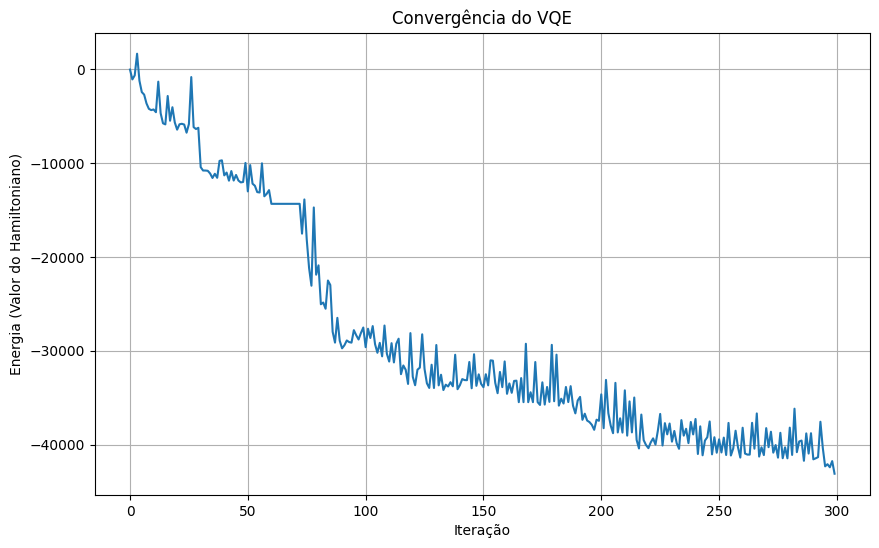

In [39]:
# Visualizar a convergência da energia
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.xlabel("Iteração")
plt.ylabel("Energia (Valor do Hamiltoniano)")
plt.title("Convergência do VQE")
plt.grid(True)
plt.show()

<svg width="1280" height="500" viewBox="0 0 1951 661" fill="none" xmlns="http://www.w3.org/2000/svg">
<g clip-path="url(#clip0_155_959)">
<rect width="1951" height="661" fill="white"/>
<path d="M2003 -32H-12V635H2003V-32Z" fill="#697077"/>
<path d="M770 91H633V257H770V91Z" fill="#D4BBFF"/>
<path d="M680.16 215.042H678.214V194.774C678.214 185.067 684.314 176.619 693.31 173.482C689.727 171.031 687.511 166.939 687.511 162.51C687.511 157.203 690.637 152.609 695.148 150.479C695.677 149.15 695.945 147.744 695.945 146.296C695.945 140.037 690.854 134.943 684.592 134.943C678.331 134.943 673.239 140.034 673.239 146.296C673.239 150.768 675.888 154.841 679.984 156.662C680.368 156.832 680.598 157.227 680.557 157.643C680.52 158.057 680.22 158.403 679.814 158.497C670.469 160.713 663.946 168.964 663.946 178.56V198.828H662V178.56C662 168.853 668.099 160.405 677.093 157.268C673.51 154.816 671.296 150.725 671.296 146.296C671.296 138.964 677.26 133 684.592 133C691.924 133 697.888 138.964 697.888 146.296C697.888 147.436 697.747 148.552 697.464 149.639C699.598 149.085 702.012 149.085 704.147 149.639C703.866 148.555 703.722 147.436 703.722 146.296C703.722 138.964 709.689 133 717.021 133C724.352 133 730.319 138.964 730.319 146.296C730.319 150.725 728.103 154.819 724.52 157.27C733.516 160.41 739.616 168.866 739.616 178.584V179.911H737.667V178.581C737.667 168.972 731.144 160.713 721.801 158.497C721.396 158.4 721.096 158.057 721.058 157.643C721.018 157.227 721.25 156.832 721.631 156.665C725.725 154.838 728.371 150.768 728.371 146.296C728.371 140.037 723.28 134.943 717.021 134.943C710.762 134.943 705.671 140.034 705.671 146.296C705.671 147.744 705.938 149.15 706.468 150.479C710.978 152.611 714.105 157.203 714.105 162.51C714.105 165.042 713.389 167.504 712.035 169.626C710.624 171.844 708.606 173.585 706.206 174.655L705.414 172.879C707.468 171.966 709.187 170.48 710.395 168.583C711.549 166.769 712.157 164.672 712.157 162.51C712.157 156.251 707.065 151.157 700.806 151.157C694.548 151.157 689.456 156.249 689.456 162.51C689.456 166.985 692.105 171.055 696.202 172.877C696.583 173.047 696.812 173.441 696.774 173.858C696.737 174.271 696.437 174.617 696.031 174.712C686.686 176.928 680.16 185.175 680.16 194.774V215.042Z" fill="#161616"/>
<path d="M725.91 211.066C727.274 211.066 728.38 209.96 728.38 208.596C728.38 207.232 727.274 206.126 725.91 206.126C724.545 206.126 723.439 207.232 723.439 208.596C723.439 209.96 724.545 211.066 725.91 211.066Z" stroke="#161616" stroke-width="1.57075" stroke-linejoin="round"/>
<path d="M716.03 193.774C717.394 193.774 718.5 192.668 718.5 191.304C718.5 189.94 717.394 188.834 716.03 188.834C714.666 188.834 713.56 189.94 713.56 191.304C713.56 192.668 714.666 193.774 716.03 193.774Z" stroke="#161616" stroke-width="1.57075" stroke-linejoin="round"/>
<path d="M717.227 193.466L724.712 206.434" stroke="#161616" stroke-width="1.57075" stroke-linejoin="round"/>
<path d="M713.608 191.786C708.446 192.502 704.913 193.959 704.913 195.627C704.913 198.011 712.102 199.95 720.97 199.95C729.838 199.95 737.026 198.011 737.026 195.627C737.026 193.465 731.135 191.674 723.44 191.353" stroke="#161616" stroke-width="1.57075" stroke-linejoin="round"/>
<path d="M728.331 208.114C733.494 207.398 737.026 205.94 737.026 204.273C737.026 201.889 729.838 199.95 720.97 199.95C712.102 199.95 704.913 201.889 704.913 204.273C704.913 206.434 710.805 208.225 718.5 208.546" stroke="#161616" stroke-width="1.57075" stroke-linejoin="round"/>
<circle cx="720.97" cy="199.95" r="17.2918" stroke="#161616" stroke-width="1.57075"/>
<path d="M643.263 104.684C645.153 104.684 646.684 103.153 646.684 101.263C646.684 99.3739 645.153 97.8423 643.263 97.8423C641.374 97.8423 639.842 99.3739 639.842 101.263C639.842 103.153 641.374 104.684 643.263 104.684Z" fill="#4D5358"/>
<path d="M759.579 104.684C761.468 104.684 763 103.153 763 101.263C763 99.3739 761.468 97.8423 759.579 97.8423C757.689 97.8423 756.158 99.3739 756.158 101.263C756.158 103.153 757.689 104.684 759.579 104.684Z" fill="#4D5358"/>
<path d="M643.263 246.842C645.153 246.842 646.684 245.31 646.684 243.421C646.684 241.532 645.153 240 643.263 240C641.374 240 639.842 241.532 639.842 243.421C639.842 245.31 641.374 246.842 643.263 246.842Z" fill="#4D5358"/>
<path d="M759.579 246.842C761.468 246.842 763 245.31 763 243.421C763 241.532 761.468 240 759.579 240C757.689 240 756.158 241.532 756.158 243.421C756.158 245.31 757.689 246.842 759.579 246.842Z" fill="#4D5358"/>
<path d="M1868.28 77.7793H1612.26V628.947H1868.28V77.7793Z" fill="#D8D3D2"/>
<path d="M1868.28 67.1118H1612.26V131.118H1868.28V67.1118Z" fill="url(#paint0_linear_155_959)"/>
<path d="M2131.42 628.948H1868.28V92.0034L2131.42 124.007V628.948Z" fill="url(#paint1_linear_155_959)"/>
<path d="M2131.42 124.007L1868.28 131.118V67.1118L2131.42 60V124.007Z" fill="url(#paint2_linear_155_959)"/>
<path d="M1349.12 628.947H1278V145.342L1349.12 124.006V628.947Z" fill="url(#paint3_linear_155_959)"/>
<path d="M1349.12 628.948H1612.26V92.0034L1349.12 124.007V628.948Z" fill="url(#paint4_linear_155_959)"/>
<path d="M1349.12 124.007L1612.26 131.118V67.1118L1349.12 60V124.007Z" fill="url(#paint5_linear_155_959)"/>
<path d="M1484.24 628.946H1477.13V63.4482L1484.24 63.6618V628.946Z" fill="#C6C6C6"/>
<path d="M1363.34 138.621L1462.91 141.466V614.723H1363.34V138.621Z" fill="url(#paint6_linear_155_959)"/>
<path d="M1598.03 145.341V614.722H1498.47V142.496L1598.03 145.341Z" fill="url(#paint7_linear_155_959)"/>
<path d="M1349.12 60L1278 81.3355V145.342L1349.12 124.007V60Z" fill="url(#paint8_linear_155_959)"/>
<path d="M1882.51 145.339V614.721H1982.08V142.495L1882.51 145.339Z" fill="url(#paint9_linear_155_959)"/>
<path d="M1839.84 159.566H1640.7V543.605H1839.84V159.566Z" fill="url(#paint10_linear_155_959)"/>
<path d="M1797.16 337.361H1793.61V351.585H1797.16V337.361Z" fill="#8F8B8B"/>
<path d="M1779.38 337.361H1775.83V351.585H1779.38V337.361Z" fill="#8F8B8B"/>
<path d="M1807.83 316.026H1804.28V376.477H1807.83V316.026Z" fill="#8F8B8B"/>
<path d="M1768.72 316.026H1765.16V376.477H1768.72V316.026Z" fill="#8F8B8B"/>
<path d="M1790.05 239.574H1782.94V312.47H1790.05V239.574Z" fill="#8F8B8B"/>
<path d="M1789.16 316.026H1783.83V333.806H1789.16V316.026Z" fill="#8F8B8B"/>
<path d="M1807.83 280.467H1804.28L1807.83 241.352H1811.39L1807.83 280.467Z" fill="#8F8B8B"/>
<path d="M1818.5 188.013H1754.49V195.125H1818.5V188.013Z" fill="#8F8B8B"/>
<path d="M1793.61 195.125H1779.38V237.796H1793.61V195.125Z" fill="#8F8B8B"/>
<path d="M1818.5 237.796H1754.49V241.352H1818.5V237.796Z" fill="#8F8B8B"/>
<path d="M1818.5 280.467H1754.49V284.023H1818.5V280.467Z" fill="#8F8B8B"/>
<path d="M1813.17 312.47H1759.83V316.026H1813.17V312.47Z" fill="#8F8B8B"/>
<path d="M1813.17 333.806H1759.83V337.361H1813.17V333.806Z" fill="#8F8B8B"/>
<path d="M1813.17 351.585H1759.83V355.141H1813.17V351.585Z" fill="#8F8B8B"/>
<path d="M1813.17 365.809H1759.83V369.365H1813.17V365.809Z" fill="#8F8B8B"/>
<path d="M1811.39 376.477H1800.72V401.368H1811.39V376.477Z" fill="#8F8B8B"/>
<path d="M1772.27 376.477H1761.6V401.368H1772.27V376.477Z" fill="#8F8B8B"/>
<path d="M1793.61 372.921H1779.38V401.368H1793.61V372.921Z" fill="#8F8B8B"/>
<path d="M1793.61 237.796H1807.83V195.125H1800.72V223.572L1793.61 237.796Z" fill="#8F8B8B"/>
<path d="M1779.38 237.796H1765.16V195.125H1772.27V223.572L1779.38 237.796Z" fill="#8F8B8B"/>
<path d="M1800.72 241.352H1797.16V280.467H1800.72V241.352Z" fill="#8F8B8B"/>
<path d="M1765.16 280.467H1768.72L1765.16 241.352H1761.6L1765.16 280.467Z" fill="#8F8B8B"/>
<path d="M1775.83 241.352H1772.27V280.467H1775.83V241.352Z" fill="#8F8B8B"/>
<path d="M1775.83 284.023H1772.27V312.47H1775.83V284.023Z" fill="#8F8B8B"/>
<path d="M1800.72 284.023H1797.16V312.47H1800.72V284.023Z" fill="#8F8B8B"/>
<path d="M1797.16 173.789H1775.83V188.013H1797.16V173.789Z" fill="#8F8B8B"/>
<path d="M1782.94 170.234H1779.38V173.79H1782.94V170.234Z" fill="#8F8B8B"/>
<path d="M1793.61 170.234H1790.05V173.79H1793.61V170.234Z" fill="#8F8B8B"/>
<path d="M1797.16 316.026H1793.61V333.806H1797.16V316.026Z" fill="#8F8B8B"/>
<path d="M1779.38 316.026H1775.83V333.806H1779.38V316.026Z" fill="#8F8B8B"/>
<path d="M1797.16 355.141L1794.5 365.809H1778.5L1775.83 355.141H1779.38L1782.94 362.253H1790.05L1793.61 355.141H1797.16Z" fill="#8F8B8B"/>
<path d="M1811.39 184.457V191.569H1800.72V173.789H1807.83V180.901L1811.39 184.457Z" fill="#8F8B8B"/>
<path d="M1761.6 184.457V191.569H1772.27V173.789H1765.16V180.901L1761.6 184.457Z" fill="#8F8B8B"/>
<path d="M1818.5 159.566H1754.49V173.789H1818.5V159.566Z" fill="#8F8B8B"/>
<path d="M1704.71 337.362H1701.15V351.585H1704.71V337.362Z" fill="#8D8D8D"/>
<path d="M1686.93 337.362H1683.38V351.585H1686.93V337.362Z" fill="#8D8D8D"/>
<path d="M1715.38 316.026H1711.82V376.477H1715.38V316.026Z" fill="#8D8D8D"/>
<path d="M1676.26 316.026H1672.71V376.477H1676.26V316.026Z" fill="#8D8D8D"/>
<path d="M1697.6 239.574H1690.49V312.47H1697.6V239.574Z" fill="#8D8D8D"/>
<path d="M1696.71 316.026H1691.38V333.806H1696.71V316.026Z" fill="#8D8D8D"/>
<path d="M1715.38 280.467H1711.82L1715.38 241.352H1718.93L1715.38 280.467Z" fill="#8D8D8D"/>
<path d="M1726.05 188.013H1662.04V195.125H1726.05V188.013Z" fill="#8D8D8D"/>
<path d="M1701.15 195.125H1686.93V237.796H1701.15V195.125Z" fill="#8D8D8D"/>
<path d="M1726.05 237.796H1662.04V241.352H1726.05V237.796Z" fill="#8D8D8D"/>
<path d="M1726.05 280.467H1662.04V284.023H1726.05V280.467Z" fill="#8D8D8D"/>
<path d="M1720.71 312.47H1667.37V316.026H1720.71V312.47Z" fill="#8D8D8D"/>
<path d="M1720.71 333.806H1667.37V337.362H1720.71V333.806Z" fill="#8D8D8D"/>
<path d="M1720.71 351.586H1667.37V355.141H1720.71V351.586Z" fill="#8D8D8D"/>
<path d="M1720.71 365.809H1667.37V369.365H1720.71V365.809Z" fill="#8D8D8D"/>
<path d="M1718.93 376.477H1708.27V401.368H1718.93V376.477Z" fill="#8D8D8D"/>
<path d="M1679.82 376.477H1669.15V401.368H1679.82V376.477Z" fill="#8D8D8D"/>
<path d="M1701.15 372.921H1686.93V401.368H1701.15V372.921Z" fill="#8D8D8D"/>
<path d="M1701.15 237.796H1715.38V195.125H1708.27V223.572L1701.15 237.796Z" fill="#8D8D8D"/>
<path d="M1686.93 237.796H1672.71V195.125H1679.82V223.572L1686.93 237.796Z" fill="#8D8D8D"/>
<path d="M1708.27 241.352H1704.71V280.467H1708.27V241.352Z" fill="#8D8D8D"/>
<path d="M1672.71 280.467H1676.26L1672.71 241.352H1669.15L1672.71 280.467Z" fill="#8D8D8D"/>
<path d="M1683.37 241.352H1679.82V280.467H1683.37V241.352Z" fill="#8D8D8D"/>
<path d="M1683.37 284.023H1679.82V312.47H1683.37V284.023Z" fill="#8D8D8D"/>
<path d="M1708.27 284.023H1704.71V312.47H1708.27V284.023Z" fill="#8D8D8D"/>
<path d="M1704.71 173.789H1683.38V188.013H1704.71V173.789Z" fill="#8D8D8D"/>
<path d="M1690.49 170.234H1686.93V173.79H1690.49V170.234Z" fill="#8D8D8D"/>
<path d="M1701.15 170.234H1697.6V173.79H1701.15V170.234Z" fill="#8D8D8D"/>
<path d="M1704.71 316.026H1701.15V333.806H1704.71V316.026Z" fill="#8D8D8D"/>
<path d="M1686.93 316.026H1683.38V333.806H1686.93V316.026Z" fill="#8D8D8D"/>
<path d="M1704.71 355.141L1702.04 365.809H1686.04L1683.38 355.141H1686.93L1690.49 362.253H1697.6L1701.15 355.141H1704.71Z" fill="#8D8D8D"/>
<path d="M1718.93 184.457V191.569H1708.27V173.789H1715.38V180.901L1718.93 184.457Z" fill="#8D8D8D"/>
<path d="M1669.15 184.457V191.569H1679.82V173.789H1672.71V180.901L1669.15 184.457Z" fill="#8D8D8D"/>
<path d="M1726.05 159.566H1662.04V173.79H1726.05V159.566Z" fill="#8D8D8D"/>
<path d="M1750.94 351.585H1747.38V365.809H1750.94V351.585Z" fill="#525252"/>
<path d="M1733.16 351.585H1729.6V365.809H1733.16V351.585Z" fill="#525252"/>
<path d="M1761.61 330.25H1758.05V390.701H1761.61V330.25Z" fill="#525252"/>
<path d="M1722.49 330.25H1718.93V390.701H1722.49V330.25Z" fill="#525252"/>
<path d="M1743.83 253.797H1736.71V326.694H1743.83V253.797Z" fill="#525252"/>
<path d="M1742.94 330.25H1737.6V348.03H1742.94V330.25Z" fill="#525252"/>
<path d="M1761.61 294.691H1758.05L1761.61 255.576H1765.16L1761.61 294.691Z" fill="#525252"/>
<path d="M1772.27 202.237H1708.27V209.349H1772.27V202.237Z" fill="#393939"/>
<path d="M1747.38 209.348H1733.16V252.019H1747.38V209.348Z" fill="#393939"/>
<path d="M1772.27 252.02H1708.27V255.575H1772.27V252.02Z" fill="#393939"/>
<path d="M1772.27 294.691H1708.27V298.247H1772.27V294.691Z" fill="#393939"/>
<path d="M1766.94 326.694H1713.6V330.25H1766.94V326.694Z" fill="#393939"/>
<path d="M1766.94 348.029H1713.6V351.585H1766.94V348.029Z" fill="#393939"/>
<path d="M1766.94 365.809H1713.6V369.365H1766.94V365.809Z" fill="#393939"/>
<path d="M1766.94 380.033H1713.6V383.589H1766.94V380.033Z" fill="#393939"/>
<path d="M1765.16 390.701H1754.49V415.592H1765.16V390.701Z" fill="#393939"/>
<path d="M1726.05 390.701H1715.38V415.592H1726.05V390.701Z" fill="#393939"/>
<path d="M1747.38 387.145H1733.16V415.592H1747.38V387.145Z" fill="#8D8D8D"/>
<path d="M1747.38 252.019H1761.61V209.348H1754.49V237.796L1747.38 252.019Z" fill="#525252"/>
<path d="M1733.16 252.019H1718.93V209.348H1726.05V237.796L1733.16 252.019Z" fill="#525252"/>
<path d="M1754.49 255.576H1750.94V294.691H1754.49V255.576Z" fill="#525252"/>
<path d="M1718.93 294.691H1722.49L1718.93 255.576H1715.38L1718.93 294.691Z" fill="#525252"/>
<path d="M1729.6 255.576H1726.05V294.691H1729.6V255.576Z" fill="#525252"/>
<path d="M1729.6 298.247H1726.05V326.694H1729.6V298.247Z" fill="#525252"/>
<path d="M1754.49 298.247H1750.94V326.694H1754.49V298.247Z" fill="#525252"/>
<path d="M1750.94 188.013H1729.6V202.237H1750.94V188.013Z" fill="#393939"/>
<path d="M1736.71 184.457H1733.16V188.013H1736.71V184.457Z" fill="#393939"/>
<path d="M1747.38 184.457H1743.83V188.013H1747.38V184.457Z" fill="#393939"/>
<path d="M1750.94 330.25H1747.38V348.03H1750.94V330.25Z" fill="#393939"/>
<path d="M1733.16 330.25H1729.6V348.03H1733.16V330.25Z" fill="#393939"/>
<path d="M1750.94 369.365L1748.27 380.033H1732.27L1729.6 369.365H1733.16L1736.71 376.477H1743.83L1747.38 369.365H1750.94Z" fill="#525252"/>
<path d="M1765.16 198.681V205.793H1754.49V188.013H1761.61V195.125L1765.16 198.681Z" fill="#393939"/>
<path d="M1715.38 198.681V205.793H1726.05V188.013H1718.93V195.125L1715.38 198.681Z" fill="#393939"/>
<path d="M1772.27 159.566H1708.27V188.013H1772.27V159.566Z" fill="#525252"/>
<path d="M1705.24 457.304L1697.63 442.76L1718.61 429.105C1720.21 428.074 1721.42 426.545 1722.06 424.767L1723.59 420.678C1724.3 418.793 1725.76 417.3 1727.61 416.588L1740.06 411.681C1742.15 410.792 1743.54 413.104 1741.05 414.313L1742.72 413.495C1745.5 412.143 1746.24 414.775 1744.11 415.877L1743.15 416.375C1744.57 415.628 1745.78 417.442 1744.07 418.509L1742.97 419.184C1743.43 419.824 1743.29 420.358 1742.3 421.176C1741.3 421.993 1736.25 425.798 1736.25 425.798L1705.21 457.304H1705.24Z" fill="#76482C"/>
<path d="M1636.47 434.013H1681.53L1697.71 442.44L1691.73 461.571L1636.47 434.013Z" fill="#4E84E4"/>
<path d="M1667.66 605.407L1662.11 628.947H1684.41C1688.92 628.947 1691.23 624.076 1686.15 620.875C1681.06 617.675 1681.35 616.004 1680.85 607.612L1667.69 605.443L1667.66 605.407Z" fill="#697077"/>
<path d="M1545.12 624.504L1547.86 593.212L1569.12 594.954L1567.88 609.107C1561.66 609.071 1557.85 617.321 1555.08 624.753C1552.45 631.936 1544.77 628.558 1545.12 624.504Z" fill="#697077"/>
<path d="M1662.11 518.714V605.194C1662.11 618.316 1651.48 628.948 1638.36 628.948C1637.61 628.948 1636.86 628.912 1636.12 628.841L1562.58 621.836L1566.14 586.277L1619.48 589.833L1606.28 559.892C1600.91 549.189 1598.14 537.383 1598.14 525.399V508.046L1662.15 518.714H1662.11Z" fill="url(#paint11_linear_155_959)"/>
<path d="M1643.37 421.922L1639.74 424.411C1637.68 425.798 1636.47 428.11 1636.47 430.563V434.012H1617.06L1617.7 428.714C1617.95 426.332 1617.2 423.949 1615.6 422.171L1613 419.291L1612.33 418.58C1610.16 416.197 1608.56 413.21 1607.92 409.832C1606.07 400.125 1612.43 390.772 1622.14 388.923C1630.5 387.323 1638.64 391.875 1641.84 399.413H1641.88C1641.98 399.627 1642.05 399.84 1642.13 400.053C1643.69 403.68 1644.47 404.961 1645.18 405.565C1645.93 406.17 1646.11 407.556 1645.54 408.161C1644.47 409.228 1644.97 411.575 1644.97 411.575L1645.86 415.806C1646.36 418.153 1645.36 420.571 1643.37 421.922Z" fill="#76482C"/>
<path d="M1640.88 397.422L1630.43 395.68C1630.43 395.68 1634.23 401.903 1634.23 407.841C1633.49 406.241 1632.06 405.245 1630.61 405.494C1629.04 405.814 1628.05 407.414 1628.05 409.37L1628.12 416.731V416.944C1628.12 418.722 1627.65 420.5 1626.77 422.065C1622.89 428.928 1613.15 429.354 1608.7 422.883L1607.49 421.14C1602.19 413.424 1603.12 403.005 1609.73 396.356L1620.04 386.043C1623.39 382.665 1628.65 382.061 1632.67 384.621L1637.26 387.501C1639.5 388.924 1640.88 391.377 1640.88 394.08V397.422Z" fill="#121619"/>
<path d="M1635.44 415.593C1636.42 415.593 1637.22 414.797 1637.22 413.815C1637.22 412.833 1636.42 412.037 1635.44 412.037C1634.46 412.037 1633.66 412.833 1633.66 413.815C1633.66 414.797 1634.46 415.593 1635.44 415.593Z" fill="white"/>
<path d="M1617.06 434.012L1610.41 437.497C1602.83 441.515 1598.07 449.374 1598.07 457.943V508.011L1653.65 516.794C1659.34 517.683 1664.1 512.491 1662.68 506.908L1661.33 501.539C1659.51 494.356 1660.87 486.711 1664.96 480.559L1672.71 468.896L1636.4 433.976H1616.99L1617.06 434.012Z" fill="url(#paint12_linear_155_959)"/>
<path d="M1636.47 434.013L1683.45 451.152L1697.71 442.44L1711.89 461.82L1695.71 472.737C1687.96 477.964 1678.22 479.386 1669.29 476.542L1622.96 461.82L1636.44 434.013H1636.47Z" fill="#78A9FF"/>
<path d="M1598.1 508.046L1706.28 524.439C1712.04 525.328 1717.01 528.92 1719.61 534.147C1721.53 537.952 1721.99 542.361 1720.96 546.486L1704.57 612.057L1667.66 605.443L1678.01 560.887L1630.43 559.145C1612.36 558.434 1598.1 543.57 1598.1 525.506V508.082V508.046Z" fill="#343A3F"/>
<path d="M1721.96 403.681C1721.53 404.392 1719.93 407.877 1718.79 410.366C1718.01 412.073 1715.45 413.567 1713.99 414.74L1697.71 442.441L1681.53 434.013L1699.63 416.233C1706.03 409.833 1709.87 398.81 1709.87 398.81L1715.38 392.8V404.108C1715.38 405.175 1715.77 406.312 1716.69 405.495C1716.98 405.103 1717.94 404.214 1718.9 402.899C1719.93 401.476 1721.32 401.939 1721.32 401.939C1721.32 401.939 1722.63 402.543 1721.96 403.681Z" fill="#76482C"/>
<path d="M835.105 450.368H944.579C946.468 450.368 948 448.837 948 446.947C948 445.058 946.468 443.526 944.579 443.526H835.105C833.216 443.526 831.684 445.058 831.684 446.947C831.684 448.837 833.216 450.368 835.105 450.368Z" fill="#21272A"/>
<path d="M834.76 451.068H882.581C884.613 451.068 886.26 449.421 886.26 447.39C886.26 445.358 884.613 443.711 882.581 443.711H834.76C832.728 443.711 831.081 445.358 831.081 447.39C831.081 449.421 832.728 451.068 834.76 451.068Z" fill="#121619"/>
<path d="M894.796 392.21H821.886C819.348 392.21 817.472 394.638 818.134 397.103L829.869 440.841C830.31 442.533 831.855 443.711 833.621 443.711H906.53C909.069 443.711 910.945 441.283 910.283 438.818L898.548 395.08C898.107 393.388 896.561 392.21 894.796 392.21Z" fill="#121619"/>
<path d="M889.939 399.568H827.403L837.261 436.354H899.797L889.939 399.568Z" fill="#343A3F"/>
<path d="M828.396 403.247H890.932L889.939 399.568H827.403L828.396 403.247Z" fill="#21272A"/>
<path d="M840.941 436.354H896.12L889.204 410.604H834.025L840.941 436.354Z" fill="#4D5358"/>
<path d="M833.071 406.925H844.107L845.063 410.604H834.027L833.071 406.925Z" fill="#4D5358"/>
<path d="M851.72 421.639H888.506L886.519 414.282H849.733L851.72 421.639Z" fill="#21272A"/>
<path d="M855.656 436.354H892.442L889.499 425.318H852.713L855.656 436.354Z" fill="#21272A"/>
<path d="M883.501 418.44H854.146L853.889 417.483H883.244L883.501 418.44Z" fill="#F4F4F4"/>
<path d="M883.502 429.475H857.09L856.833 428.518H883.245L883.502 429.475Z" fill="#4D5358"/>
<path d="M869.853 433.153H858.082L857.824 432.197H869.595L869.853 433.153Z" fill="#FF7EB6"/>
<path d="M880.892 433.153H869.12L868.863 432.197H880.634L880.892 433.153Z" fill="#A56EFF"/>
<path d="M839.691 417.961H847.048L846.055 414.282H838.698L839.691 417.961Z" fill="#343A3F"/>
<path d="M842.632 428.996H849.989L849.033 425.318H841.676L842.632 428.996Z" fill="#343A3F"/>
<path d="M1153.72 87.7369H852.842C849.063 87.7369 846 90.8002 846 94.579V354.579C846 358.358 849.063 361.421 852.842 361.421H1153.72C1157.5 361.421 1160.56 358.358 1160.56 354.579V94.579C1160.56 90.8002 1157.5 87.7369 1153.72 87.7369Z" fill="#A2A9B0"/>
<path d="M1146 101H860V348H1146V101Z" fill="#F4F4F4"/>
<path d="M852.842 87.7369H859.684V101.421H846V94.579C846 90.8159 849.079 87.7369 852.842 87.7369Z" fill="#343A3F"/>
<path d="M1159.68 101.421H1146V87.7369H1152.84C1156.61 87.7369 1159.68 90.8159 1159.68 94.579V101.421Z" fill="#343A3F"/>
<path d="M846 347.737H859.684V361.421H852.842C849.079 361.421 846 358.342 846 354.579V347.737Z" fill="#343A3F"/>
<path d="M1152.84 361.421H1146V347.737H1159.68V354.579C1159.68 358.342 1156.61 361.421 1152.84 361.421Z" fill="#343A3F"/>
<path d="M914.421 197.211H893.895V217.737H914.421V197.211Z" fill="#FF7EB6"/>
<path d="M914.421 159.579H893.895V180.105H914.421V159.579Z" fill="#A6C8FF"/>
<path d="M955.474 207.474H934.948V228H955.474V207.474Z" fill="#E0E0E0"/>
<path d="M1030.74 204.053H1010.21V224.579H1030.74V204.053Z" fill="#F4F4F4"/>
<path d="M1064.95 238.263H1044.42V258.789H1064.95V238.263Z" fill="#E0E0E0"/>
<path d="M1064.95 204.053H1044.42V224.579H1064.95V204.053Z" fill="#F4F4F4"/>
<path d="M986.264 176.684H965.737V197.211H986.264V176.684Z" fill="#D4BBFF"/>
<path d="M989.684 210.895H969.158V231.421H989.684V210.895Z" fill="#78A9FF"/>
<path d="M1030.74 238.263H1010.21V258.789H1030.74V238.263Z" fill="#FF7EB6"/>
<path d="M1075.21 303.263H1054.68V323.789H1075.21V303.263Z" fill="#78A9FF"/>
<path d="M1075.21 272.474H1054.68V293H1075.21V272.474Z" fill="#78A9FF"/>
<path d="M1041 293H1020.47V313.526H1041V293Z" fill="#D4BBFF"/>
<path d="M955.474 163H934.948V183.526H955.474V163Z" fill="#E0E0E0"/>
<path d="M1082.02 212.126C1119.31 236.176 1102.54 273.978 1085.68 280.547" stroke="#A56EFF" stroke-width="1.71053" stroke-miterlimit="10"/>
<path d="M1086.4 275.142L1085.75 280.753L1091.22 282.395" stroke="#A56EFF" stroke-width="1.71053" stroke-miterlimit="10"/>
<path d="M1017.53 190.197L1021.91 193.789L1026.26 190.094" stroke="#A56EFF" stroke-width="1.71053" stroke-miterlimit="10"/>
<path d="M1021.91 193.789V166.353C1021.91 155.987 1013.53 147.605 1003.16 147.605H974.324" stroke="#A56EFF" stroke-width="1.71053" stroke-miterlimit="10"/>
<path d="M550.632 87.7367H71.6844C67.9056 87.7367 64.8423 90.8 64.8423 94.5788V347.737C64.8423 351.516 67.9056 354.579 71.6844 354.579H550.632C554.411 354.579 557.474 351.516 557.474 347.737V94.5788C557.474 90.8 554.411 87.7367 550.632 87.7367Z" fill="#343A3F"/>
<path d="M543.789 87.7369H64.8421C61.0633 87.7369 58 90.8003 58 94.579V347.737C58 351.516 61.0633 354.579 64.8421 354.579H543.789C547.568 354.579 550.632 351.516 550.632 347.737V94.579C550.632 90.8003 547.568 87.7369 543.789 87.7369Z" fill="#121619"/>
<path d="M543.79 94.5788H64.8423V347.737H543.79V94.5788Z" fill="#4D5358"/>
<path d="M533.526 101.421H396.684C394.795 101.421 393.263 102.953 393.263 104.842V173.263C393.263 175.152 394.795 176.684 396.684 176.684H533.526C535.416 176.684 536.947 175.152 536.947 173.263V104.842C536.947 102.953 535.416 101.421 533.526 101.421Z" fill="#697077"/>
<path d="M533.526 183.526H396.684C394.795 183.526 393.263 185.058 393.263 186.947V255.368C393.263 257.258 394.795 258.789 396.684 258.789H533.526C535.416 258.789 536.947 257.258 536.947 255.368V186.947C536.947 185.058 535.416 183.526 533.526 183.526Z" fill="#343A3F"/>
<path d="M533.526 265.631H396.684C394.795 265.631 393.263 267.163 393.263 269.053V337.474C393.263 339.363 394.795 340.895 396.684 340.895H533.526C535.416 340.895 536.947 339.363 536.947 337.474V269.053C536.947 267.163 535.416 265.631 533.526 265.631Z" fill="#343A3F"/>
<path d="M526.684 272.474H506.158C504.268 272.474 502.737 274.005 502.737 275.895V282.737C502.737 284.626 504.268 286.158 506.158 286.158H526.684C528.574 286.158 530.105 284.626 530.105 282.737V275.895C530.105 274.005 528.574 272.474 526.684 272.474Z" fill="#4D5358"/>
<path d="M526.684 190.368H506.158C504.268 190.368 502.737 191.9 502.737 193.789V200.631C502.737 202.521 504.268 204.053 506.158 204.053H526.684C528.574 204.053 530.105 202.521 530.105 200.631V193.789C530.105 191.9 528.574 190.368 526.684 190.368Z" fill="#4D5358"/>
<path d="M526.684 108.263H506.158C504.268 108.263 502.737 109.795 502.737 111.684V118.526C502.737 120.416 504.268 121.947 506.158 121.947H526.684C528.574 121.947 530.105 120.416 530.105 118.526V111.684C530.105 109.795 528.574 108.263 526.684 108.263Z" fill="#4D5358"/>
<path d="M143.526 306.684H102.474C96.8054 306.684 92.2104 311.279 92.2104 316.947C92.2104 322.615 96.8054 327.21 102.474 327.21H143.526C149.194 327.21 153.789 322.615 153.789 316.947C153.789 311.279 149.194 306.684 143.526 306.684Z" fill="#343A3F"/>
<path d="M211.948 306.684H170.895C165.227 306.684 160.632 311.279 160.632 316.947C160.632 322.615 165.227 327.21 170.895 327.21H211.948C217.616 327.21 222.211 322.615 222.211 316.947C222.211 311.279 217.616 306.684 211.948 306.684Z" fill="#343A3F"/>
<path d="M280.369 306.684H239.316C233.648 306.684 229.053 311.279 229.053 316.947C229.053 322.615 233.648 327.21 239.316 327.21H280.369C286.037 327.21 290.632 322.615 290.632 316.947C290.632 311.279 286.037 306.684 280.369 306.684Z" fill="#343A3F"/>
<path d="M348.789 306.684H307.737C302.069 306.684 297.474 311.279 297.474 316.947C297.474 322.615 302.069 327.21 307.737 327.21H348.789C354.458 327.21 359.053 322.615 359.053 316.947C359.053 311.279 354.458 306.684 348.789 306.684Z" fill="#343A3F"/>
<path d="M509.579 176.684H420.632C422.787 170.218 427.85 165.155 434.316 163L454.842 156.124H475.369L495.895 163C502.361 165.155 507.424 170.218 509.579 176.684Z" fill="#BE95FF"/>
<path d="M461.889 148.495C471.374 148.495 479.063 140.806 479.063 131.321C479.063 121.836 471.374 114.147 461.889 114.147C452.405 114.147 444.716 121.836 444.716 131.321C444.716 140.806 452.405 148.495 461.889 148.495Z" fill="#E58D79"/>
<path d="M445.126 127.592C444.237 131.8 442.937 132.997 442.218 133.852C441.637 134.571 441.808 135.802 443.245 136.521C444.374 137.068 444.579 138.334 444.579 139.018V146.647C444.579 148.152 445.708 149.418 447.213 149.623L454.842 150.615V156.123H475.368L474.41 151.368C473.795 148.426 474.205 145.347 475.505 142.61L477.695 138.094" fill="#E58D79"/>
<path d="M474.411 145.895H472.906C468.903 145.895 465.927 142.2 466.782 138.266L467.193 136.35L459.119 135.392C459.119 133.613 459.119 129.713 459.119 126.531C459.119 123.589 460.179 120.716 462.129 118.492L463.737 116.645L459.461 116.747C457.682 116.747 456.861 116.063 456.724 114.866C463.19 112.608 474.343 114.01 478.448 124.137C482.553 134.263 475.129 142.166 474.343 145.826L474.411 145.895Z" fill="#E0E0E0"/>
<path d="M463.223 139.531C465.491 139.531 467.329 137.693 467.329 135.426C467.329 133.159 465.491 131.321 463.223 131.321C460.956 131.321 459.118 133.159 459.118 135.426C459.118 137.693 460.956 139.531 463.223 139.531Z" fill="#E58D79"/>
<path d="M443.895 137.034C443.895 137.034 443.758 137.342 443.553 137.889C442.834 139.839 444.545 140.455 444.545 140.455H449.368L448.547 138.881C448.171 138.094 447.487 137.615 446.495 137.478L443.895 137V137.034Z" fill="#E0E0E0"/>
<path d="M502.737 258.789H427.474C427.474 253.281 430.793 248.321 435.856 246.166L454.843 238.229H465.687L475.369 238.263L494.356 246.2C499.453 248.321 502.737 253.281 502.737 258.789Z" fill="#FF7EB6"/>
<path d="M461.889 230.6C471.374 230.6 479.063 222.911 479.063 213.426C479.063 203.941 471.374 196.252 461.889 196.252C452.405 196.252 444.716 203.941 444.716 213.426C444.716 222.911 452.405 230.6 461.889 230.6Z" fill="#A75638"/>
<path d="M445.126 209.697C444.237 213.905 442.937 215.102 442.218 215.957C441.637 216.676 441.808 217.907 443.245 218.626C444.374 219.173 444.579 220.439 444.579 221.123V227.726C444.579 229.813 446.118 231.592 448.205 231.865L451.626 232.31C453.474 232.55 454.842 234.123 454.842 235.971V238.229H475.368L474.41 233.473C473.795 230.531 474.205 227.452 475.505 224.715L477.695 220.2" fill="#A75638"/>
<path d="M459.153 217.532L467.226 218.489L463.189 238.263H475.403C481.629 238.263 486.076 232.311 484.366 226.324L478.926 207.645C473.897 190.368 449.129 191.224 445.332 208.842C453.303 208.842 459.153 203.061 459.153 203.061C459.153 203.061 459.153 215.787 459.153 217.532Z" fill="#121619"/>
<path d="M463.223 221.637C465.491 221.637 467.329 219.799 467.329 217.531C467.329 215.264 465.491 213.426 463.223 213.426C460.956 213.426 459.118 215.264 459.118 217.531C459.118 219.799 460.956 221.637 463.223 221.637Z" fill="#A75638"/>
<path d="M509.947 340.561H421C423.155 334.095 428.218 329.032 434.684 326.876L455.211 320H475.737L496.263 326.876C502.729 329.032 507.792 334.095 509.947 340.561Z" fill="#78A9FF"/>
<path d="M461.889 312.705C471.374 312.705 479.063 305.016 479.063 295.531C479.063 286.047 471.374 278.358 461.889 278.358C452.405 278.358 444.716 286.047 444.716 295.531C444.716 305.016 452.405 312.705 461.889 312.705Z" fill="#D2745A"/>
<path d="M445.126 291.802C444.237 296.01 442.937 297.207 442.218 298.063C441.637 298.781 441.808 300.013 443.245 300.731C444.374 301.279 444.579 302.544 444.579 303.229V310.857C444.579 312.363 445.708 313.629 447.213 313.834L454.842 314.826V320.334H475.368L474.41 315.579C473.795 312.636 474.205 309.557 475.505 306.821L477.695 302.305" fill="#D2745A"/>
<path d="M459.153 299.637L459.324 311.063C459.358 313.424 457.306 315.305 454.945 314.997L447.008 314.005C445.229 313.8 443.895 312.295 443.895 310.482V301.245L446.221 301.792C447.59 302.134 448.821 302.853 449.745 303.913L450.806 305.111L454.295 302.1C455.835 300.766 456.724 298.85 456.724 296.832V293.89C456.724 291.94 457.819 288.792 460.077 287.15C455.937 288.347 451.25 286.09 451.25 286.09L448.616 284.619C447.692 285.748 446.94 287.082 446.94 287.082L445.879 284.516C444.408 280.924 447.077 276.99 450.942 276.99H467.295C470.237 276.99 472.94 278.563 474.411 281.095L474.992 282.087L477.045 283.216C479.645 284.653 481.287 287.424 481.287 290.4V296.25C481.287 300.971 474.582 307.54 474.24 311.645C470.203 310.55 467.398 306.89 467.398 302.682V299.569H459.221L459.153 299.637Z" fill="#A75638"/>
<path d="M463.223 303.742C465.491 303.742 467.329 301.904 467.329 299.637C467.329 297.369 465.491 295.531 463.223 295.531C460.956 295.531 459.118 297.369 459.118 299.637C459.118 301.904 460.956 303.742 463.223 303.742Z" fill="#D2745A"/>
<path d="M480.5 207.474C485.223 207.474 489.053 203.644 489.053 198.921C489.053 194.197 485.223 190.368 480.5 190.368C475.776 190.368 471.947 194.197 471.947 198.921C471.947 203.644 475.776 207.474 480.5 207.474Z" fill="#121619"/>
<path d="M386.421 115.105H71.6843V282.737C71.6843 284.618 73.2238 286.158 75.1054 286.158H383C384.882 286.158 386.421 284.618 386.421 282.737V115.105Z" fill="#343A3F"/>
<path d="M71.6843 115.105H386.421V104.842C386.421 102.96 384.882 101.421 383 101.421H75.1054C73.2238 101.421 71.6843 102.96 71.6843 104.842V115.105Z" fill="#121619"/>
<path d="M372.738 145.895V286.158H86.7717V132.21C86.7717 130.329 88.3112 128.789 90.1928 128.789H144.93C146.811 128.789 148.351 130.329 148.351 132.21V139.052C148.351 140.934 149.89 142.474 151.772 142.474H369.316C371.198 142.474 372.738 144.013 372.738 145.895Z" fill="#697077"/>
<path d="M359.053 169.842H146.947V286.158H359.053V169.842Z" fill="#21272A"/>
<path d="M133.263 169.842H99.0527V183.526H133.263V169.842Z" fill="#343A3F"/>
<path d="M162.411 275.894V270.558H343.521V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M179.105 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M197.579 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M216.018 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M234.492 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M252.966 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M271.439 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M289.914 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M308.353 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M326.826 270.284V275.894" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M336.063 206.824H345.3" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M320.122 206.824H329.358" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M304.179 206.824H313.416" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M288.203 206.824H297.44" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M272.26 206.824H281.497" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M256.318 206.824H265.555" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M240.377 206.824H249.614" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M224.434 206.824H233.67" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M208.492 206.824H217.695" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M192.516 206.824H201.753" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M176.574 206.824H185.811" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M160.632 206.824H169.869" stroke="#697077" stroke-width="3.42105" stroke-miterlimit="10"/>
<path d="M162.924 187.187C164.19 187.187 165.216 186.16 165.216 184.895C165.216 183.629 164.19 182.602 162.924 182.602C161.658 182.602 160.632 183.629 160.632 184.895C160.632 186.16 161.658 187.187 162.924 187.187Z" fill="#A56EFF"/>
<path d="M176.779 187.187C178.045 187.187 179.072 186.16 179.072 184.894C179.072 183.629 178.045 182.602 176.779 182.602C175.514 182.602 174.487 183.629 174.487 184.894C174.487 186.16 175.514 187.187 176.779 187.187Z" fill="#A56EFF"/>
<path d="M190.635 187.187C191.901 187.187 192.927 186.16 192.927 184.894C192.927 183.629 191.901 182.602 190.635 182.602C189.369 182.602 188.343 183.629 188.343 184.894C188.343 186.16 189.369 187.187 190.635 187.187Z" fill="#A56EFF"/>
<path d="M204.489 187.187C205.755 187.187 206.781 186.16 206.781 184.894C206.781 183.629 205.755 182.602 204.489 182.602C203.224 182.602 202.197 183.629 202.197 184.894C202.197 186.16 203.224 187.187 204.489 187.187Z" fill="#A56EFF"/>
<path d="M218.345 187.187C219.611 187.187 220.637 186.16 220.637 184.894C220.637 183.629 219.611 182.602 218.345 182.602C217.079 182.602 216.053 183.629 216.053 184.894C216.053 186.16 217.079 187.187 218.345 187.187Z" fill="#A56EFF"/>
<path d="M232.2 191.805C233.466 191.805 234.492 190.779 234.492 189.513C234.492 188.247 233.466 187.221 232.2 187.221C230.934 187.221 229.908 188.247 229.908 189.513C229.908 190.779 230.934 191.805 232.2 191.805Z" fill="#A56EFF"/>
<path d="M246.056 191.805C247.322 191.805 248.348 190.779 248.348 189.513C248.348 188.247 247.322 187.221 246.056 187.221C244.79 187.221 243.764 188.247 243.764 189.513C243.764 190.779 244.79 191.805 246.056 191.805Z" fill="#A56EFF"/>
<path d="M259.877 191.805C261.143 191.805 262.169 190.779 262.169 189.513C262.169 188.247 261.143 187.221 259.877 187.221C258.611 187.221 257.585 188.247 257.585 189.513C257.585 190.779 258.611 191.805 259.877 191.805Z" fill="#A56EFF"/>
<path d="M273.732 194.131C274.998 194.131 276.025 193.105 276.025 191.839C276.025 190.573 274.998 189.547 273.732 189.547C272.467 189.547 271.44 190.573 271.44 191.839C271.44 193.105 272.467 194.131 273.732 194.131Z" fill="#A56EFF"/>
<path d="M287.587 194.131C288.853 194.131 289.88 193.105 289.88 191.839C289.88 190.573 288.853 189.547 287.587 189.547C286.322 189.547 285.295 190.573 285.295 191.839C285.295 193.105 286.322 194.131 287.587 194.131Z" fill="#A56EFF"/>
<path d="M301.443 196.423C302.708 196.423 303.735 195.397 303.735 194.131C303.735 192.865 302.708 191.839 301.443 191.839C300.177 191.839 299.15 192.865 299.15 194.131C299.15 195.397 300.177 196.423 301.443 196.423Z" fill="#A56EFF"/>
<path d="M315.298 194.131C316.564 194.131 317.59 193.105 317.59 191.839C317.59 190.573 316.564 189.547 315.298 189.547C314.032 189.547 313.006 190.573 313.006 191.839C313.006 193.105 314.032 194.131 315.298 194.131Z" fill="#A56EFF"/>
<path d="M329.153 191.805C330.419 191.805 331.446 190.779 331.446 189.513C331.446 188.247 330.419 187.221 329.153 187.221C327.888 187.221 326.861 188.247 326.861 189.513C326.861 190.779 327.888 191.805 329.153 191.805Z" fill="#A56EFF"/>
<path d="M342.973 191.805C344.239 191.805 345.265 190.779 345.265 189.513C345.265 188.247 344.239 187.221 342.973 187.221C341.707 187.221 340.681 188.247 340.681 189.513C340.681 190.779 341.707 191.805 342.973 191.805Z" fill="#A56EFF"/>
<path d="M162.923 184.894H176.779H190.634H204.489H218.344L232.2 189.513H246.055H259.876L273.731 191.839H287.586L301.442 194.131L315.297 191.839L329.152 189.513H342.973" stroke="#A56EFF" stroke-width="1.71053" stroke-miterlimit="10"/>
<path d="M162.924 233.371C164.19 233.371 165.216 232.345 165.216 231.079C165.216 229.813 164.19 228.787 162.924 228.787C161.658 228.787 160.632 229.813 160.632 231.079C160.632 232.345 161.658 233.371 162.924 233.371Z" fill="#F4F4F4"/>
<path d="M176.779 242.573C178.045 242.573 179.072 241.547 179.072 240.281C179.072 239.015 178.045 237.989 176.779 237.989C175.514 237.989 174.487 239.015 174.487 240.281C174.487 241.547 175.514 242.573 176.779 242.573Z" fill="#F4F4F4"/>
<path d="M190.635 242.573C191.901 242.573 192.927 241.547 192.927 240.281C192.927 239.015 191.901 237.989 190.635 237.989C189.369 237.989 188.343 239.015 188.343 240.281C188.343 241.547 189.369 242.573 190.635 242.573Z" fill="#F4F4F4"/>
<path d="M204.489 242.573C205.755 242.573 206.781 241.547 206.781 240.281C206.781 239.015 205.755 237.989 204.489 237.989C203.224 237.989 202.197 239.015 202.197 240.281C202.197 241.547 203.224 242.573 204.489 242.573Z" fill="#F4F4F4"/>
<path d="M218.345 242.573C219.611 242.573 220.637 241.547 220.637 240.281C220.637 239.015 219.611 237.989 218.345 237.989C217.079 237.989 216.053 239.015 216.053 240.281C216.053 241.547 217.079 242.573 218.345 242.573Z" fill="#F4F4F4"/>
<path d="M232.2 247.192C233.466 247.192 234.492 246.166 234.492 244.9C234.492 243.634 233.466 242.608 232.2 242.608C230.934 242.608 229.908 243.634 229.908 244.9C229.908 246.166 230.934 247.192 232.2 247.192Z" fill="#F4F4F4"/>
<path d="M246.056 247.192C247.322 247.192 248.348 246.166 248.348 244.9C248.348 243.634 247.322 242.608 246.056 242.608C244.79 242.608 243.764 243.634 243.764 244.9C243.764 246.166 244.79 247.192 246.056 247.192Z" fill="#F4F4F4"/>
<path d="M259.877 244.9C261.143 244.9 262.169 243.874 262.169 242.608C262.169 241.342 261.143 240.316 259.877 240.316C258.611 240.316 257.585 241.342 257.585 242.608C257.585 243.874 258.611 244.9 259.877 244.9Z" fill="#F4F4F4"/>
<path d="M273.732 244.9C274.998 244.9 276.025 243.874 276.025 242.608C276.025 241.342 274.998 240.316 273.732 240.316C272.467 240.316 271.44 241.342 271.44 242.608C271.44 243.874 272.467 244.9 273.732 244.9Z" fill="#F4F4F4"/>
<path d="M287.587 240.281C288.853 240.281 289.88 239.255 289.88 237.989C289.88 236.723 288.853 235.697 287.587 235.697C286.322 235.697 285.295 236.723 285.295 237.989C285.295 239.255 286.322 240.281 287.587 240.281Z" fill="#F4F4F4"/>
<path d="M301.443 231.045C302.708 231.045 303.735 230.019 303.735 228.753C303.735 227.487 302.708 226.461 301.443 226.461C300.177 226.461 299.15 227.487 299.15 228.753C299.15 230.019 300.177 231.045 301.443 231.045Z" fill="#F4F4F4"/>
<path d="M315.298 231.045C316.564 231.045 317.59 230.019 317.59 228.753C317.59 227.487 316.564 226.461 315.298 226.461C314.032 226.461 313.006 227.487 313.006 228.753C313.006 230.019 314.032 231.045 315.298 231.045Z" fill="#F4F4F4"/>
<path d="M329.153 233.371C330.419 233.371 331.446 232.345 331.446 231.079C331.446 229.813 330.419 228.787 329.153 228.787C327.888 228.787 326.861 229.813 326.861 231.079C326.861 232.345 327.888 233.371 329.153 233.371Z" fill="#F4F4F4"/>
<path d="M342.973 233.371C344.239 233.371 345.265 232.345 345.265 231.079C345.265 229.813 344.239 228.787 342.973 228.787C341.707 228.787 340.681 229.813 340.681 231.079C340.681 232.345 341.707 233.371 342.973 233.371Z" fill="#F4F4F4"/>
<path d="M162.923 231.079L176.779 240.281H190.634H204.489H218.344L232.2 244.9H246.055L259.876 242.608H273.731L287.586 237.989L301.442 228.752H315.297L329.152 231.079H342.973" stroke="#F4F4F4" stroke-width="1.71053" stroke-miterlimit="10"/>
<path d="M983.169 290.845L983.511 292.282C984.196 291.358 984.982 290.469 985.872 289.716L987.89 285.611L984.161 288.279C983.34 288.861 982.964 289.887 983.169 290.845Z" fill="#21272A"/>
<path d="M1087.61 573.526H1080.84V535.895H1087.61V573.526Z" fill="#4D5358"/>
<path d="M1053.4 460.632H1114.98C1122.54 460.632 1128.67 466.758 1128.67 474.316V522.21C1128.67 529.768 1122.54 535.895 1114.98 535.895H1053.4C1045.84 535.895 1039.72 529.768 1039.72 522.21V474.316C1039.72 466.758 1045.84 460.632 1053.4 460.632Z" stroke="#343A3F" stroke-width="6.84211" stroke-miterlimit="10" stroke-linecap="round"/>
<path d="M1060.45 429.842H1107.93C1117.49 429.842 1125.24 437.592 1125.24 447.153V480.953C1125.24 490.513 1117.49 498.263 1107.93 498.263H1060.45C1050.89 498.263 1043.14 490.513 1043.14 480.953V447.153C1043.14 437.592 1050.89 429.842 1060.45 429.842Z" fill="#D2745A"/>
<path d="M1114.98 532.474H1053.4C1047.73 532.474 1043.14 527.879 1043.14 522.21C1043.14 516.542 1047.73 511.947 1053.4 511.947H1114.98C1120.65 511.947 1125.24 516.542 1125.24 522.21C1125.24 527.879 1120.65 532.474 1114.98 532.474Z" fill="#D2745A"/>
<path d="M1036.3 628.263C1032.52 628.263 1029.46 625.2 1029.46 621.421C1029.46 617.642 1032.52 614.579 1036.3 614.579C1040.08 614.579 1043.14 617.642 1043.14 621.421C1043.14 625.2 1040.08 628.263 1036.3 628.263Z" fill="#4D5358"/>
<path d="M1084.19 628.263C1080.41 628.263 1077.35 625.2 1077.35 621.421C1077.35 617.642 1080.41 614.579 1084.19 614.579C1087.97 614.579 1091.03 617.642 1091.03 621.421C1091.03 625.2 1087.97 628.263 1084.19 628.263Z" fill="#4D5358"/>
<path d="M1132.09 628.263C1128.31 628.263 1125.24 625.2 1125.24 621.421C1125.24 617.642 1128.31 614.579 1132.09 614.579C1135.86 614.579 1138.93 617.642 1138.93 621.421C1138.93 625.2 1135.86 628.263 1132.09 628.263Z" fill="#4D5358"/>
<path d="M1073.93 539.316H1094.46C1096.34 539.316 1097.88 540.847 1097.88 542.737C1097.88 544.626 1096.34 546.158 1094.46 546.158H1073.93C1072.04 546.158 1070.51 544.626 1070.51 542.737C1070.51 540.847 1072.04 539.316 1073.93 539.316Z" fill="#343A3F"/>
<path d="M1029.45 609.995V614.579H1036.3V611.158L1077.35 594.053H1091.03L1132.09 611.158V614.579H1138.93V609.995C1138.93 608.626 1138.11 607.395 1136.84 606.847L1097.23 589.879C1093.46 588.271 1091 584.542 1091 580.437V573.526H1077.32V580.437C1077.32 584.542 1074.85 588.237 1071.09 589.879L1031.47 606.847C1030.21 607.395 1029.39 608.626 1029.39 609.995H1029.45Z" fill="#343A3F"/>
<path d="M1080.77 614.579H1087.61L1091.03 594.053H1077.35L1080.77 614.579Z" fill="#343A3F"/>
<path d="M439.939 487.692L440.008 488.479C441 501.718 452.05 511.982 465.358 511.982H523.174V607.771H564.192V504.9C564.192 491.113 554.066 479.447 540.416 477.497L482.429 469.218L439.939 487.726V487.692Z" fill="#21272A"/>
<path d="M456.395 364.158C456.395 366.826 457.011 369.324 458.072 371.582L460.569 377.158C461.356 378.903 461.664 380.818 461.458 382.734L460.74 389.029H479.624V386.361C479.624 384.513 480.89 382.905 482.703 382.495L487.972 381.229C489.853 380.784 491.222 379.074 491.187 377.124L491.085 372.471C491.085 372.471 490.777 370.076 492.248 369.358C493.685 368.64 493.856 367.408 493.274 366.69C492.59 365.834 491.324 364.705 490.435 360.737C490.435 360.634 490.435 360.532 490.366 360.429C488.656 352.697 481.78 346.95 473.569 346.95C464.093 346.95 456.395 354.647 456.395 364.158Z" fill="#93633F"/>
<path d="M479.624 389.029L509.455 416.158L536.824 399.053L540.245 419.579L516.297 436.684L485.508 440.105L479.624 389.029Z" fill="#C1C7CD"/>
<path d="M455.471 390.158L446.816 397.821C437.647 405.963 432.926 418.039 434.158 430.252L439.974 488C470.763 488 471.824 470.894 495.771 470.894V450.368" fill="url(#paint13_linear_155_959)"/>
<path d="M455.471 390.158L461.321 383.829L479.623 389.029L495.771 429.671L523.139 429.876V450.403H494.334C484.892 450.403 476.442 444.587 473.055 435.795L455.505 390.192L455.471 390.158Z" fill="#E0E0E0"/>
<path d="M543.906 443.526H653.379C655.269 443.526 656.8 445.058 656.8 446.947C656.8 448.837 655.269 450.368 653.379 450.368H543.906C542.016 450.368 540.485 448.837 540.485 446.947C540.485 445.058 542.016 443.526 543.906 443.526Z" fill="#21272A"/>
<path d="M543.906 443.526H588.379C590.269 443.526 591.8 445.058 591.8 446.947C591.8 448.837 590.269 450.368 588.379 450.368H543.906C542.016 450.368 540.485 448.837 540.485 446.947C540.485 445.058 542.016 443.526 543.906 443.526Z" fill="#121619"/>
<path d="M600.981 395.632H533.176C530.815 395.632 529.07 397.89 529.686 400.182L540.599 440.858C541.01 442.432 542.447 443.526 544.089 443.526H611.894C614.255 443.526 615.999 441.268 615.384 438.976L604.47 398.3C604.06 396.726 602.623 395.632 600.981 395.632Z" fill="#121619"/>
<path d="M537.029 402.474H595.187L604.355 436.684H546.197L537.029 402.474Z" fill="#343A3F"/>
<path d="M596.11 405.895H537.952L537.028 402.474H595.186L596.11 405.895Z" fill="#21272A"/>
<path d="M600.934 436.684H549.618L543.22 412.737H594.536L600.934 436.684Z" fill="#4D5358"/>
<path d="M593.613 409.316H583.35L584.273 412.737H594.537L593.613 409.316Z" fill="#4D5358"/>
<path d="M587.25 436.684H553.039L547.565 416.158H581.776L587.25 436.684Z" fill="#21272A"/>
<path d="M559.265 420.024H579.723L579.484 419.135H559.026L559.265 420.024Z" fill="#F4F4F4"/>
<path d="M567.031 423.445H573.805L573.565 422.556H566.792L567.031 423.445Z" fill="#F4F4F4"/>
<path d="M561.113 426.866H574.729L574.49 425.977H560.874L561.113 426.866Z" fill="#F4F4F4"/>
<path d="M562.037 430.287H570.487L570.247 429.398H561.797L562.037 430.287Z" fill="#F4F4F4"/>
<path d="M562.961 433.708H571.411L571.171 432.819H562.721L562.961 433.708Z" fill="#F4F4F4"/>
<path d="M592.928 419.579H586.086L585.197 416.158H592.039L592.928 419.579Z" fill="#343A3F"/>
<path d="M471.208 363.952L471.585 364.226C471.79 364.192 471.995 364.158 472.235 364.158C474.287 364.158 475.998 365.663 476.271 367.613C476.34 367.818 476.34 368.023 476.34 368.229L477.742 378.526C478.085 381.023 480.445 382.768 482.942 382.358L489.374 381.297C491.735 380.886 493.377 378.731 493.069 376.371L492.248 369.358L488.793 370.829C486.569 371.752 484.037 371.547 481.984 370.247L478.906 368.229L477.777 361.113L471.208 363.952Z" fill="#343A3F"/>
<path d="M461.492 380.819C480.205 365.526 485.816 352.116 485.816 352.116C487.355 353.724 488.073 354.955 488.073 354.955C493.102 342.161 484.413 327.04 463.579 346.984C442.744 366.963 453.384 379.792 461.492 380.819Z" fill="#343A3F"/>
<path d="M553.347 628.263H523.139V607.737H536.824C537.303 613.689 545.41 616.666 552.766 618.684C559.881 620.634 557.282 628.263 553.382 628.263H553.347Z" fill="#121619"/>
<path d="M523.139 450.368H529.982H534.361C535.832 450.368 537.2 449.479 537.782 448.11L539.218 444.792L544.863 446.331C545.992 446.639 547.121 445.784 547.121 444.621C547.121 443.937 546.745 443.321 546.129 443.047L534.942 437.437C533.984 436.958 532.855 436.889 531.829 437.231L523.174 440.105V450.368H523.139Z" fill="#93633F"/>
<path d="M545 392.21H555.024C556.905 392.21 558.445 393.75 558.445 395.632V399.053C558.445 400.934 556.905 402.474 555.024 402.474H546.163C544.692 402.474 543.392 401.516 542.913 400.147L541.784 396.726C541.032 394.503 542.708 392.21 545.034 392.21H545Z" fill="#93633F"/>
<path d="M542.435 393.34L540.177 395.632H542.435V393.34Z" fill="#93633F"/>
<path d="M1009.99 323.106C1010.67 323.858 1010.88 324.919 1010.43 325.671C1009.96 326.527 1009.78 327.553 1009.99 328.716C1010.19 329.879 1010.74 330.906 1011.53 331.761C1012.25 332.514 1012.42 333.574 1011.97 334.361C1011.49 335.216 1011.29 336.277 1011.49 337.406C1011.7 338.535 1012.25 339.595 1013.03 340.45C1013.72 341.203 1013.92 342.263 1013.48 343.016C1013 343.871 1012.83 344.932 1013 346.061C1013.17 347.19 1013.75 348.25 1014.54 349.106C1015.26 349.858 1015.43 350.919 1014.98 351.706C1014.51 352.561 1014.3 353.621 1014.51 354.75C1014.71 355.879 1015.26 356.94 1016.04 357.795C1016.76 358.548 1016.93 359.608 1016.49 360.395C1016.01 361.25 1015.81 362.311 1016.01 363.44C1016.22 364.569 1016.76 365.629 1017.55 366.485C1018.23 367.237 1018.44 368.298 1017.99 369.05C1017.52 369.906 1017.34 370.932 1017.55 372.095C1018.06 374.935 1020.73 377.227 1023.57 377.227C1026.41 377.227 1028.29 374.935 1027.81 372.095C1027.61 370.966 1027.06 369.906 1026.27 369.05C1025.56 368.298 1025.38 367.237 1025.79 366.485C1026.27 365.629 1026.48 364.569 1026.27 363.44C1026.07 362.311 1025.52 361.25 1024.73 360.395C1024.02 359.642 1023.84 358.582 1024.29 357.795C1024.77 356.94 1024.97 355.879 1024.77 354.75C1024.56 353.621 1024.02 352.561 1023.23 351.706C1022.51 350.953 1022.34 349.892 1022.78 349.106C1023.26 348.25 1023.47 347.19 1023.26 346.061C1023.06 344.932 1022.51 343.871 1021.72 343.016C1021.04 342.263 1020.83 341.203 1021.28 340.45C1021.76 339.595 1021.96 338.535 1021.76 337.406C1021.55 336.277 1021.01 335.216 1020.22 334.361C1019.5 333.608 1019.33 332.548 1019.77 331.761C1020.25 330.906 1020.46 329.845 1020.25 328.716C1020.05 327.587 1019.5 326.527 1018.71 325.671C1017.99 324.919 1017.82 323.858 1018.23 323.106C1018.71 322.25 1018.92 321.19 1018.71 320.061C1018.51 318.932 1017.96 317.871 1017.17 317.016C1016.46 316.264 1016.28 315.203 1016.73 314.416C1017.21 313.561 1017.41 312.5 1017.21 311.371C1016.69 308.532 1014.03 306.24 1011.19 306.24C1008.35 306.24 1006.47 308.532 1006.94 311.371C1007.15 312.5 1007.7 313.561 1008.48 314.416C1009.2 315.169 1009.37 316.229 1008.93 317.016C1008.45 317.871 1008.24 318.932 1008.45 320.061C1008.66 321.19 1009.2 322.25 1009.99 323.106Z" fill="#21272A"/>
<path d="M980.089 317.427L983.579 319.787C985.529 321.121 986.726 323.345 986.726 325.706V329.058H1005.37L1004.79 323.927C1004.55 321.634 1005.27 319.342 1006.81 317.632L1009.3 314.861L1009.95 314.177C1012.04 311.884 1013.58 309.011 1014.2 305.761C1015.98 296.421 1009.85 287.424 1000.51 285.645C992.439 284.106 984.605 288.484 981.526 295.737C981.423 296.011 981.321 296.25 981.218 296.49C979.747 299.877 978.994 301.108 978.31 301.656C977.626 302.237 977.421 303.571 978.002 304.153C979.029 305.179 978.55 307.437 978.55 307.437L977.694 311.508C977.215 313.8 978.173 316.127 980.089 317.427Z" fill="#93633F"/>
<path d="M985.015 295.189C986.383 298.952 988.71 302.202 988.504 305.008C988.915 302.818 990.659 301.279 992.37 301.587C993.978 301.894 995.004 303.742 994.765 305.795H994.799L994.525 308.223C994.08 312.192 996.304 315.955 999.999 317.495L1005.44 319.718C1006.43 317.7 1008.35 317.392 1012.38 312.123C1016.42 306.889 1018.2 294.984 1009.06 288.21C1002.02 282.942 995.415 282.326 989.496 284.721C985.425 286.363 983.51 291.084 985.015 295.189Z" fill="#21272A"/>
<path d="M1019.19 416.158L1032.88 607.737H998.665L988.402 416.158H1019.19Z" fill="url(#paint14_linear_155_959)"/>
<path d="M1019.19 416.158H964.455L950.771 607.737H984.981L1002.09 440.721L1019.19 416.158Z" fill="#343A3F"/>
<path d="M986.726 327.21L966.815 338.91L960.794 352.903C956.484 362.892 955.423 373.976 957.681 384.616L964.455 416.158C988.402 416.158 997.673 425.497 1020.05 425.497L1025.21 358.513C1025.73 351.705 1023.23 345 1018.37 340.176L1005.2 327.21H986.726Z" fill="url(#paint15_linear_155_959)"/>
<path d="M944.202 320.882L942.013 313.903C940.816 308.874 942.321 304.906 944.852 299.911L947.863 294.369C948.171 293.787 948.137 293.103 947.76 292.556C947.521 292.213 947.11 292.042 946.734 292.042C946.323 292.042 945.947 292.213 945.673 292.556L941.739 298.029L934.521 285.303C934.145 284.619 933.289 284.379 932.605 284.721C932.092 284.961 931.818 285.474 931.818 286.021C931.818 286.192 931.852 286.398 931.921 286.569L934.247 292.111L930.997 295.669C929.902 296.866 929.252 298.371 929.15 299.945L928.842 304.119C928.739 305.385 928.979 306.65 929.56 307.813L930.929 310.619C931.51 311.816 931.921 313.082 932.126 314.382C932.126 314.382 933.084 320.848 934.316 329.058L944.202 320.882Z" fill="#93633F"/>
<path d="M984.981 607.737V628.263H964.934C960.589 628.263 958.366 623.576 963.258 620.497C968.15 617.418 970.818 615.845 971.297 607.737H984.981Z" fill="#121619"/>
<path d="M1022.61 607.737V628.263H1002.57C998.221 628.263 995.997 623.576 1000.89 620.497C1005.78 617.418 1008.45 615.845 1008.93 607.737H1022.61Z" fill="#121619"/>
<path d="M986.726 327.21L952.276 346.402L944.236 320.881L924.771 327.518L931.818 359.539C934.52 371.855 948.273 378.115 959.357 372.06L1005.54 347.737L986.76 327.21H986.726Z" fill="#FF7EB6"/>
<path d="M997.947 323.584C998.631 324.337 998.836 325.397 998.391 326.15C997.912 327.005 997.741 328.032 997.947 329.195C998.152 330.358 998.699 331.384 999.486 332.24C1000.2 332.992 1000.38 334.053 999.931 334.839C999.452 335.695 999.247 336.755 999.452 337.884C999.657 339.013 1000.2 340.074 1000.99 340.929C1001.68 341.682 1001.88 342.742 1001.44 343.495C1000.96 344.35 1000.79 345.411 1000.96 346.539C1001.13 347.668 1001.71 348.729 1002.5 349.584C1003.22 350.337 1003.39 351.397 1002.94 352.184C1002.46 353.04 1002.26 354.1 1002.46 355.229C1002.67 356.358 1003.22 357.418 1004 358.274C1004.72 359.026 1004.89 360.087 1004.45 360.874C1003.97 361.729 1003.76 362.789 1003.97 363.918C1004.17 365.047 1004.72 366.108 1005.51 366.963C1006.19 367.716 1006.4 368.776 1005.95 369.529C1005.47 370.384 1005.3 371.411 1005.51 372.574C1006.02 375.413 1008.69 377.705 1011.53 377.705C1014.37 377.705 1016.25 375.413 1015.77 372.574C1015.57 371.445 1015.02 370.384 1014.23 369.529C1013.51 368.776 1013.34 367.716 1013.75 366.963C1014.23 366.108 1014.44 365.047 1014.23 363.918C1014.03 362.789 1013.48 361.729 1012.69 360.874C1011.97 360.121 1011.8 359.061 1012.25 358.274C1012.73 357.418 1012.93 356.358 1012.73 355.229C1012.52 354.1 1011.97 353.04 1011.19 352.184C1010.47 351.432 1010.3 350.371 1010.74 349.584C1011.22 348.729 1011.43 347.668 1011.22 346.539C1011.01 345.411 1010.47 344.35 1009.68 343.495C1009 342.742 1008.79 341.682 1009.24 340.929C1009.72 340.074 1009.92 339.013 1009.71 337.884C1009.51 336.755 1008.96 335.695 1008.18 334.839C1007.46 334.087 1007.29 333.026 1007.73 332.24C1008.21 331.384 1008.41 330.324 1008.21 329.195C1008 328.066 1007.46 327.005 1006.67 326.15C1005.95 325.397 1005.78 324.337 1006.19 323.584C1006.67 322.729 1006.88 321.668 1006.67 320.54C1006.47 319.411 1005.92 318.35 1005.13 317.495C1004.41 316.742 1004.24 315.682 1004.69 314.895C1005.17 314.039 1005.37 312.979 1005.17 311.85C1004.65 309.011 1001.98 306.718 999.144 306.718C996.305 306.718 994.423 309.011 994.902 311.85C995.107 312.979 995.654 314.039 996.441 314.895C997.16 315.647 997.331 316.708 996.886 317.495C996.407 318.35 996.202 319.411 996.407 320.54C996.613 321.668 997.16 322.729 997.947 323.584Z" fill="#21272A"/>
<path d="M1005.09 300.051C1002.31 294.074 1003.54 287.599 1007.86 285.586C1012.17 283.574 1017.93 286.788 1020.72 292.764C1023.51 298.74 1022.27 305.216 1017.95 307.228C1013.64 309.24 1007.88 306.027 1005.09 300.051Z" fill="#21272A"/>
<path d="M1159.46 450.368H502.613C498.85 450.368 495.771 453.447 495.771 457.21C495.771 464.771 501.895 470.895 509.455 470.895H1152.61C1160.17 470.895 1166.3 464.771 1166.3 457.21C1166.3 453.447 1163.22 450.368 1159.46 450.368Z" fill="#A2A9B0"/>
<path d="M591.56 470.895V628.263H639.455L659.023 510.818C659.57 507.534 662.444 505.105 665.763 505.105H996.271C999.623 505.105 1002.46 507.534 1003.01 510.818L1022.58 628.263H1070.47V470.895H591.526H591.56Z" fill="#E0E0E0"/>
<path d="M728.574 363.611L727.616 361.113C727.171 359.745 726.932 358.342 727.034 356.905L727.548 350.337C727.616 349.721 727.513 349.105 727.274 348.558H727.308L726.521 345.924C726.248 344.966 725.358 344.282 724.366 344.213L722.313 344.111L720.432 342.776C719.132 341.853 717.319 342.332 716.669 343.768L713.042 351.671C712.221 353.45 712.495 355.503 713.727 357.008L716.19 359.984C716.805 360.737 717.934 362.037 718.413 363.439L720.261 368.605L734.253 412.532L747.424 404.766L728.54 363.645L728.574 363.611Z" fill="#E58D79"/>
<path d="M796.823 607.737V628.263H776.776C772.431 628.263 770.208 623.576 775.1 620.497C779.992 617.418 782.66 615.845 783.139 607.737H796.823Z" fill="#121619"/>
<path d="M732.268 628.263H762.476L762.613 607.737H748.929C748.45 613.689 740.205 616.666 732.884 618.684C725.768 620.634 728.368 628.263 732.268 628.263Z" fill="#121619"/>
<path d="M796.823 436.684V607.737H762.613L759.192 436.684H796.823Z" fill="#343A3F"/>
<path d="M735.244 436.684V607.737H772.876V486.529C772.876 481.021 775.544 475.821 780.026 472.605L789.639 465.729C794.121 462.513 796.789 457.347 796.789 451.805V436.65H735.21L735.244 436.684Z" fill="#4D5358"/>
<path d="M723.305 323.618C723.75 325.261 724.023 326.561 724.263 327.587C724.571 328.955 724.502 332.171 724.4 332.855C724.297 333.54 724.639 333.95 725.255 334.053C725.871 334.155 726.213 334.224 726.213 334.224C726.213 334.224 726.658 334.292 727.068 335.113C727.308 335.558 728.402 337.884 729.394 340.005C730.352 342.092 732.781 343.084 734.937 342.297L736.784 341.613C738.7 340.929 740.752 342.058 741.197 344.042L741.642 346.026L759.192 340.895C759.192 340.895 753.171 333.711 756.045 325.09C757.687 320.54 757.447 315.34 754.916 310.79C750.331 302.511 739.863 299.5 731.55 304.118C724.502 308.053 721.287 316.161 723.305 323.618Z" fill="#E58D79"/>
<path d="M742.163 344.866L728 371.789L729.916 400.355L728.616 418.316C728.24 423.653 729.608 428.955 732.584 433.368L734.842 436.789H796.421L797.721 428.955C799.124 420.608 798.44 412.055 795.771 404.05L779.487 355.197C777.263 348.526 771.653 343.566 764.742 342.197L758.79 341L742.163 344.866Z" fill="url(#paint16_linear_155_959)"/>
<path d="M721.56 310.858C724.092 299.329 730.592 297.242 737.776 296.626C744.96 296.011 753.992 300.595 755.497 308.874L721.56 310.858Z" fill="url(#paint17_linear_155_959)"/>
<path d="M709.792 434.905C708.698 439.216 705.071 441.439 705.071 441.439L697.066 446.776C695.493 447.734 695.492 450.368 695.492 450.368H712.598C716.498 450.368 718.311 445.031 719.303 442.773C720.295 440.516 738.016 402.405 738.016 402.405L720.432 395.392L709.758 434.939L709.792 434.905Z" fill="#E58D79"/>
<path d="M722.723 320.778L757.036 317.494C757.857 317.426 758.473 316.673 758.371 315.852L757.413 307.436C757.31 306.615 756.592 306.034 755.805 306.136L721.731 309.386C720.91 309.455 720.328 310.173 720.397 310.994L721.081 319.444C721.15 320.265 721.868 320.881 722.689 320.813L722.723 320.778Z" fill="#4D5358"/>
<path d="M722.724 320.779C726.179 325.91 731.926 320.608 734.937 328.236C737.947 335.865 741.437 339.971 751.905 337.234C754.95 336.31 765.179 333.847 765.179 333.847C762.75 323.071 759.089 326.081 757.002 317.46L722.689 320.744L722.724 320.779Z" fill="#EAB2A2"/>
<path d="M720.466 395.597L731.105 356.153C733.5 347.326 742.771 342.331 751.46 345.171C759.363 347.771 763.913 356.016 761.929 364.124L751.118 407.845L720.5 395.597H720.466Z" fill="#121619"/>
<path d="M471.823 573.526H465.05V528.334H471.823V573.526Z" fill="#4D5358"/>
<path d="M420.508 628.263C416.729 628.263 413.665 625.2 413.665 621.421C413.665 617.642 416.729 614.579 420.508 614.579C424.286 614.579 427.35 617.642 427.35 621.421C427.35 625.2 424.286 628.263 420.508 628.263Z" fill="#4D5358"/>
<path d="M468.403 628.263C464.624 628.263 461.56 625.2 461.56 621.421C461.56 617.642 464.624 614.579 468.403 614.579C472.181 614.579 475.245 617.642 475.245 621.421C475.245 625.2 472.181 628.263 468.403 628.263Z" fill="#4D5358"/>
<path d="M516.297 628.263C512.518 628.263 509.455 625.2 509.455 621.421C509.455 617.642 512.518 614.579 516.297 614.579C520.076 614.579 523.139 617.642 523.139 621.421C523.139 625.2 520.076 628.263 516.297 628.263Z" fill="#4D5358"/>
<path d="M458.139 539.316H478.665C480.555 539.316 482.086 540.847 482.086 542.737C482.086 544.626 480.555 546.158 478.665 546.158H458.139C456.25 546.158 454.718 544.626 454.718 542.737C454.718 540.847 456.25 539.316 458.139 539.316Z" fill="#343A3F"/>
<path d="M420.2 495.184L414.043 433.605C413.837 431.587 415.411 429.842 417.464 429.842H418.729C427.521 429.842 434.877 436.513 435.766 445.237L439.94 486.974C440.556 493.029 435.8 498.263 429.711 498.263H423.621C421.877 498.263 420.406 496.929 420.2 495.184Z" fill="#D2745A"/>
<path d="M437.613 511.947H506.034C511.702 511.947 516.297 516.542 516.297 522.21C516.297 527.879 511.702 532.474 506.034 532.474H437.613C431.945 532.474 427.35 527.879 427.35 522.21C427.35 516.542 431.945 511.947 437.613 511.947Z" fill="#D2745A"/>
<path d="M413.665 460.632L507.778 472.776C514.586 473.666 519.718 479.482 519.718 486.358V522.21C519.718 529.771 513.594 535.895 506.034 535.895H430.77" stroke="#343A3F" stroke-width="6.84211" stroke-miterlimit="10" stroke-linecap="round"/>
<path d="M418.455 477.737L415.718 450.368H412.434C410.416 450.368 408.842 452.113 409.013 454.132L411.065 474.658C411.237 476.403 412.708 477.737 414.487 477.737H418.455Z" fill="#343A3F"/>
<path d="M413.665 609.995V614.579H420.508V611.158L461.56 594.053H475.244L516.297 611.158V614.579H523.139V609.995C523.139 608.626 522.318 607.395 521.052 606.847L481.437 589.879C477.673 588.271 475.21 584.542 475.21 580.437V573.526H461.526V580.437C461.526 584.542 459.063 588.237 455.3 589.879L415.684 606.847C414.418 607.395 413.597 608.626 413.597 609.995H413.665Z" fill="#343A3F"/>
<path d="M464.981 614.579H471.824L475.245 594.053H461.56L464.981 614.579Z" fill="#343A3F"/>
<path d="M140.782 390.572L144.223 392.627C154.278 398.585 167.107 395.846 173.955 386.257L193.899 358.381L177.697 345.984L162.664 368.175L146.528 336.908C143.521 331.121 138.276 326.874 132.063 325.299L128.455 324.374L140.749 390.606L140.782 390.572Z" fill="url(#paint18_linear_155_959)"/>
<path d="M206.727 327.56C206.226 327.354 205.658 327.526 205.357 327.971C205.223 328.176 204.99 328.45 204.789 328.69C203.72 328.348 202.417 329.82 202.417 329.82C201.448 330.882 200.58 331.738 199.778 332.457L201.482 327.252C201.682 326.635 201.315 325.985 200.713 325.848C200.212 325.745 199.745 325.985 199.544 326.464L196.003 334.889C195.402 335.128 194.8 335.334 194.199 335.471C193.564 335.573 192.963 335.71 192.295 335.745C191.092 335.813 190.324 334.409 190.959 333.382L193.331 329.512C193.798 328.758 193.564 327.765 192.829 327.286C192.128 326.841 191.192 327.046 190.725 327.731C189.856 328.998 188.52 330.984 187.685 332.149C186.348 333.964 183.308 334.306 180.302 342.012L177.763 345.916L185.714 351.977C186.348 350.196 187.585 348.347 189.155 347.662C192.896 345.984 200.68 341.84 207.361 332.183C207.829 331.498 207.662 330.539 207.027 330.06H206.994L207.361 329.204C207.662 328.553 207.361 327.8 206.727 327.56Z" fill="#93633F"/>
<path d="M115.125 608.582V629.129H95.5486C91.3059 629.129 89.1344 624.438 93.9116 621.355C98.6888 618.273 101.295 616.698 101.762 608.582H115.125Z" fill="#121619"/>
<path d="M101.762 594.883H115.125V608.582H101.762V594.883Z" fill="#F3EDE4"/>
<path d="M74.9699 608.582H155.213V400.709C155.213 393.346 153.777 386.086 151.004 379.305L128.488 324.34H105.103L85.0588 334.614C85.0588 335.333 88.5331 409.955 88.5331 409.955H88.3995L74.9699 608.582Z" fill="url(#paint19_linear_155_959)"/>
<path d="M110.114 280.197C117.998 278.656 125.615 283.04 128.655 290.266C130.292 294.238 131.06 295.574 131.762 296.19C132.463 296.772 132.631 298.108 132.063 298.69C131.06 299.718 131.528 301.978 131.528 301.978L132.363 306.053C132.831 308.313 131.896 310.642 130.025 311.943L126.617 314.341C124.713 315.676 123.544 317.902 123.544 320.265V324.34H105.036L105.872 318.519C106.139 316.224 105.404 313.93 103.901 312.217L100.861 308.758H100.894C98.8226 306.43 97.3193 303.587 96.718 300.3C94.9808 290.985 100.961 281.944 110.047 280.197H110.114Z" fill="#93633F"/>
<path d="M126.082 369.887H129.59V369.785L132.095 325.265L128.487 324.34L126.316 364.1L126.082 369.75V369.887Z" fill="#FF7EB6"/>
<path d="M105.036 332.97L126.083 369.751L126.149 369.888H129.657L129.59 369.785L107.909 331.909L105.036 332.97Z" fill="#FF7EB6"/>
<path d="M120.136 368.86H133.499C134.422 368.86 135.169 369.627 135.169 370.572V377.421C135.169 378.367 134.422 379.134 133.499 379.134H120.136C119.214 379.134 118.466 378.367 118.466 377.421V370.572C118.466 369.627 119.214 368.86 120.136 368.86Z" fill="#F4F4F4"/>
<path d="M116.394 388.483L118.566 387.011C119.702 386.154 120.671 385.161 121.406 383.894L124.713 378.244C125.013 377.73 125.448 377.285 125.915 376.942H125.882L127.987 375.23C128.755 374.614 129.824 374.545 130.659 375.093L132.363 376.189H134.601C136.138 376.189 137.307 377.627 137.04 379.203L135.47 387.73C135.102 389.647 133.733 391.189 131.895 391.668L128.254 392.661C127.318 392.901 125.715 393.312 124.512 394.168L120.136 397.284" fill="#93633F"/>
<path d="M85.0588 334.614C79.9141 336.532 76.2393 341.224 75.5378 346.771L69.4243 394.647C68.7228 400.024 70.2929 405.469 73.667 409.647C80.0811 417.524 91.3392 418.962 99.4237 412.935L121.773 396.257L108.41 378.826L96.4171 387.627L100.86 334.614H84.992H85.0588Z" fill="#343A3F"/>
<path d="M124.078 283.896L122.775 288.862C121.372 294.204 121.706 299.82 123.677 304.957L126.917 313.347C127.953 316.053 128.487 318.964 128.487 321.875V324.306H124.211C120.503 324.306 117.029 326.224 115.024 329.443C113.02 332.662 109.546 334.58 105.837 334.58H85.0583L87.4636 319.786C88.0649 315.984 89.468 312.389 91.5392 309.204L91.8733 308.656C93.978 305.437 95.3476 301.772 95.9155 297.937L96.4835 294.135C98.4211 280.916 113.721 274.992 123.71 283.553L124.044 283.862L124.078 283.896Z" fill="url(#paint20_linear_155_959)"/>
<path d="M220.357 409.955V398.791C220.357 395.093 218.921 391.531 216.382 388.928L208.732 381.086" stroke="#697077" stroke-width="3.4246" stroke-miterlimit="10"/>
<path d="M213.042 387.832L205.391 379.99" stroke="#121619" stroke-width="6.84919" stroke-miterlimit="10" stroke-linecap="round"/>
<path d="M115.125 409.955H235.39V629.129H115.125V409.955Z" fill="#C1C7CD"/>
<path d="M115.125 409.955H168.576V629.129H115.125V409.955Z" fill="#F4F4F4"/>
<path d="M155.213 409.955H248.752V560.637H155.213V409.955Z" fill="#4D5358"/>
<path d="M155.213 409.955H168.576V560.637H155.213V409.955Z" fill="#343A3F"/>
<rect y="629" width="1955" height="32" fill="#A2A9B0"/>
</g>
<defs>
<linearGradient id="paint0_linear_155_959" x1="1740.27" y1="51.7502" x2="1740.27" y2="144.631" gradientUnits="userSpaceOnUse">
<stop stop-color="#E5E0DF"/>
<stop offset="1" stop-color="#F7F3F2"/>
</linearGradient>
<linearGradient id="paint1_linear_155_959" x1="1999.85" y1="-36.7565" x2="1999.85" y2="742.381" gradientUnits="userSpaceOnUse">
<stop stop-color="#CAC5C4"/>
<stop offset="1" stop-color="#E5E0DF"/>
</linearGradient>
<linearGradient id="paint2_linear_155_959" x1="-933.782" y1="42.9316" x2="-930.226" y2="146.16" gradientUnits="userSpaceOnUse">
<stop stop-color="#CAC5C4"/>
<stop offset="1" stop-color="#E5E0DF"/>
</linearGradient>
<linearGradient id="paint3_linear_155_959" x1="1313.56" y1="146.978" x2="1313.56" y2="656.541" gradientUnits="userSpaceOnUse">
<stop offset="0.44" stop-color="#E5E0DF"/>
<stop offset="0.99" stop-color="#CAC5C4"/>
</linearGradient>
<linearGradient id="paint4_linear_155_959" x1="1480.69" y1="-36.7565" x2="1480.69" y2="742.381" gradientUnits="userSpaceOnUse">
<stop stop-color="#CAC5C4"/>
<stop offset="1" stop-color="#E5E0DF"/>
</linearGradient>
<linearGradient id="paint5_linear_155_959" x1="1480.69" y1="42.9316" x2="1480.69" y2="146.16" gradientUnits="userSpaceOnUse">
<stop stop-color="#CAC5C4"/>
<stop offset="1" stop-color="#E5E0DF"/>
</linearGradient>
<linearGradient id="paint6_linear_155_959" x1="1413.13" y1="24.4405" x2="1413.13" y2="715.32" gradientUnits="userSpaceOnUse">
<stop stop-color="#E5E0DF"/>
<stop offset="0.99" stop-color="#CAC5C4"/>
</linearGradient>
<linearGradient id="paint7_linear_155_959" x1="1548.25" y1="29.2756" x2="1548.25" y2="714.502" gradientUnits="userSpaceOnUse">
<stop stop-color="#E5E0DF"/>
<stop offset="0.99" stop-color="#CAC5C4"/>
</linearGradient>
<linearGradient id="paint8_linear_155_959" x1="1313.56" y1="39.5179" x2="1313.56" y2="136.523" gradientUnits="userSpaceOnUse">
<stop stop-color="#E5E0DF"/>
<stop offset="1" stop-color="#F7F3F2"/>
</linearGradient>
<linearGradient id="paint9_linear_155_959" x1="1932.29" y1="29.2743" x2="1932.29" y2="714.5" gradientUnits="userSpaceOnUse">
<stop stop-color="#E5E0DF"/>
<stop offset="0.99" stop-color="#CAC5C4"/>
</linearGradient>
<linearGradient id="paint10_linear_155_959" x1="1740.27" y1="39.3402" x2="1740.27" y2="589.406" gradientUnits="userSpaceOnUse">
<stop stop-color="#CAC5C4"/>
<stop offset="0.99" stop-color="#ADA8A8"/>
</linearGradient>
<linearGradient id="paint11_linear_155_959" x1="1612.33" y1="571.769" x2="1681.99" y2="543.926" gradientUnits="userSpaceOnUse">
<stop offset="0.03" stop-color="#343A3F"/>
<stop offset="0.98" stop-color="#121619"/>
</linearGradient>
<linearGradient id="paint12_linear_155_959" x1="1640" y1="470" x2="1673" y2="510.5" gradientUnits="userSpaceOnUse">
<stop stop-color="#78A9FF"/>
<stop offset="1" stop-color="#4E84E4"/>
</linearGradient>
<linearGradient id="paint13_linear_155_959" x1="458" y1="443" x2="479.5" y2="458" gradientUnits="userSpaceOnUse">
<stop stop-color="#E0E0E0"/>
<stop offset="1" stop-color="#C1C7CD"/>
</linearGradient>
<linearGradient id="paint14_linear_155_959" x1="1032.09" y1="498.845" x2="974.444" y2="534.013" gradientUnits="userSpaceOnUse">
<stop stop-color="#343A3F"/>
<stop offset="0.89" stop-color="#21272A"/>
</linearGradient>
<linearGradient id="paint15_linear_155_959" x1="966.5" y1="420" x2="998" y2="366.5" gradientUnits="userSpaceOnUse">
<stop stop-color="#EE5396"/>
<stop offset="1" stop-color="#FF7EB6"/>
</linearGradient>
<linearGradient id="paint16_linear_155_959" x1="728" y1="430.5" x2="769.5" y2="379.5" gradientUnits="userSpaceOnUse">
<stop stop-color="#343A3F"/>
<stop offset="1" stop-color="#121619"/>
</linearGradient>
<linearGradient id="paint17_linear_155_959" x1="754.368" y1="308.84" x2="721.252" y2="301.45" gradientUnits="userSpaceOnUse">
<stop stop-color="#343A3F"/>
<stop offset="1" stop-color="#4D5358"/>
</linearGradient>
<linearGradient id="paint18_linear_155_959" x1="158.855" y1="346.771" x2="134.488" y2="399.778" gradientUnits="userSpaceOnUse">
<stop stop-color="#343A3F"/>
<stop offset="0.34" stop-color="#2C3136"/>
<stop offset="0.89" stop-color="#161B1E"/>
<stop offset="1" stop-color="#121619"/>
</linearGradient>
<linearGradient id="paint19_linear_155_959" x1="153.977" y1="455.811" x2="79.8422" y2="487.339" gradientUnits="userSpaceOnUse">
<stop offset="0.06" stop-color="#343A3F"/>
<stop offset="0.19" stop-color="#2A2F34"/>
<stop offset="0.41" stop-color="#121619"/>
</linearGradient>
<linearGradient id="paint20_linear_155_959" x1="128.487" y1="307.115" x2="80.5817" y2="307.115" gradientUnits="userSpaceOnUse">
<stop offset="0.23" stop-color="#C1C7CD"/>
<stop offset="0.47" stop-color="#BDC3CA"/>
<stop offset="0.65" stop-color="#B3B9C0"/>
<stop offset="0.82" stop-color="#A3A9B0"/>
<stop offset="0.97" stop-color="#8B919A"/>
<stop offset="1" stop-color="#878D96"/>
</linearGradient>
<clipPath id="clip0_155_959">
<rect width="1951" height="661" fill="white"/>
</clipPath>
</defs>
</svg>

## Recursos

- Exemplo adaptado de _The QuBlog_: <https://www.thequblog.com/posts/how-to-solve-optimization-problems-with-aqua-qio-3/>

- Curso sobre VQE (_IBM Quantum Learning_): <https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design>

- Documentação do Qiskit: <https://quantum.cloud.ibm.com/docs/en>
- Documentação do Qiskit Aer: <https://qiskit.github.io/qiskit-aer/apidocs/aer.html>
- Documentação do Qiskit Optimization: <https://qiskit-community.github.io/qiskit-optimization/apidocs/qiskit_optimization.html>

- Documentação D-Wave (Construção de Modelos Quadráticos): <https://docs.dwavequantum.com/en/latest/industrial_optimization/model_construction_qm.html#opt-model-construction-qm>

## Nota de Copyright e Licenciamento
<p>
  &copy; Copyright 2025, Kauê Miziara. Todos os direitos reservados.
</p>
<p>
  O texto, as análises e a estrutura deste notebook foram desenvolvidos por <i>&lt;Kauê Miziara&gt;</i> como material de estudo e referência.
</p>
<p>
  O código-fonte contido neste notebook está licenciado sob os termos da <b>Licença MIT</b>. <br>
  Você pode obter uma cópia da licença em <a href="https://opensource.org/licenses/MIT">https://opensource.org/licenses/MIT</a>.
</p>

> Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

> The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

> THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.